In [1]:
%load_ext autoreload
%autoreload 2

# %config InlineBackend.figure_formats = ['svg']

from IPython.display import display, Markdown

import sys, os
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import pickle

import push_pull as pp
import noise_models as noise
import fig_plot as fplot
import model_fitting as fit

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

In [6]:
# label = '210620'

label = '210728'

flag_label = 'Flag Antibody'
myc_label = 'Myc Antibody'

df_list = []


try:
    with open('/projectnb/biophys/jrocks/proj_push_pull/data/pushnomixture_{}.pkl'.format(label), 'rb') as pkl_file:

        data = pickle.load(pkl_file)
        df_list.append(data['df_info'])
except:
    pass
    
    
for i, f in enumerate(glob.iglob(r'/projectnb/biophys/jrocks/proj_push_pull/data/pushnomixture_{}_*.pkl'.format(label))):
    
    if i % 1000 == 0:
        print(i)
   
    with open(f, 'rb') as pkl_file:
    
        data = pickle.load(pkl_file)

        df_info = data['df_info']
        
    df_list.append(df_info)
    
    
print(len(df_list))
    
df_info = pd.concat(df_list)

df_info.set_index(['dataset', 'seed'], inplace=True)
df_info.sort_index(inplace=True)

df_info = df_info[~df_info.index.duplicated(keep='last')].copy()

print("seeds", df_info.index.get_level_values('seed').nunique())

df_info.reset_index(inplace=True)


display(df_info)


with open('/projectnb/biophys/jrocks/proj_push_pull/data/pushnomixture_{}.pkl'.format(label), 'wb') as pkl_file:
    
    data = {'df_info': df_info}
    pickle.dump(data, pkl_file)


0
2
seeds 1


dataset  seed   zipper kinase model  WT_empty_frac  WT_anti_scale  \
0       375     0  generic    375  push            0.0            0.0   
1       419     0  generic    419  push            0.0            0.0   
2  421_1000     0  generic    421  push            0.0            0.0   
3     E_250     0     EE_E     wt  push            0.0            0.0   
4     L_250     0     EE_L     wt  push            0.0            0.0   
5    RR_250     0       RR     wt  push            0.0            0.0   
6   S+E_250     0      S+E     wt  push            0.0            0.0   

   ST_empty_frac  ST_anti_scale  bg_phospho_rate  kinase_phospho_rate  \
0            0.0            0.0         0.002979             0.023752   
1            0.0            0.0         0.002979             0.264209   
2            0.0            0.0         0.002979             0.000025   
3            0.0            0.0         0.002979             2.426555   
4            0.0            0.0         0.002979             2.426555   
5            0.0            0.0         0.002979             2.426555   
6            0.0            0.0         0.002979             2.426555   

   kinase_bind_affin  
0       4.928544e+03  
1       4.928544e+03  
2       4.928544e+03  
3       1.338238e+04  
4       4.848112e-01  
5       1.991475e+06  
6       2.028556e+05

In [8]:
for f in glob.iglob(r'/projectnb/biophys/jrocks/proj_push_pull/data/push_{}_*.pkl'.format(label)):
    os.remove(f)

In [7]:
df_avg = df_info.groupby(['dataset', 'zipper', 'kinase']).mean()
df_err_low = df_avg - df_info.groupby(['dataset', 'zipper', 'kinase']).quantile(0.25)
df_err_up = df_info.groupby(['dataset', 'zipper', 'kinase']).quantile(0.75) - df_avg
df_std = df_info.groupby(['dataset', 'zipper', 'kinase']).std()


display(df_avg)

df_aff = pd.DataFrame({'mean': df_avg['kinase_bind_affin'],
                      'err_low': df_err_low['kinase_bind_affin'],
                      'err_up': df_err_up['kinase_bind_affin'],
                      'sem': df_std['kinase_bind_affin'],
                      'pe': 100*df_std['kinase_bind_affin']/df_avg['kinase_bind_affin']},
                     index=df_avg.index)

df_aff = df_aff.groupby(['zipper']).first().sort_values('mean')

display(df_aff)


df_prate = pd.DataFrame({'mean': df_avg['kinase_phospho_rate'],
                      'err_low': df_err_low['kinase_phospho_rate'],
                      'err_up': df_err_up['kinase_phospho_rate'],
                      'sem': df_std['kinase_phospho_rate'],
                      'pe': 100*df_std['kinase_phospho_rate']/df_avg['kinase_phospho_rate']},
                     index=df_avg.index)

df_prate = df_prate.groupby(['kinase']).first().sort_values('mean')


display(df_prate)

seed  WT_empty_frac  WT_anti_scale  ST_empty_frac  \
dataset  zipper  kinase                                                      
375      generic 375        0            0.0            0.0            0.0   
419      generic 419        0            0.0            0.0            0.0   
421_1000 generic 421        0            0.0            0.0            0.0   
E_250    EE_E    wt         0            0.0            0.0            0.0   
L_250    EE_L    wt         0            0.0            0.0            0.0   
RR_250   RR      wt         0            0.0            0.0            0.0   
S+E_250  S+E     wt         0            0.0            0.0            0.0   

                         ST_anti_scale  bg_phospho_rate  kinase_phospho_rate  \
dataset  zipper  kinase                                                        
375      generic 375               0.0         0.002979             0.023752   
419      generic 419               0.0         0.002979             0.264209   
421_1000 generic 421               0.0         0.002979             0.000025   
E_250    EE_E    wt                0.0         0.002979             2.426555   
L_250    EE_L    wt                0.0         0.002979             2.426555   
RR_250   RR      wt                0.0         0.002979             2.426555   
S+E_250  S+E     wt                0.0         0.002979             2.426555   

                         kinase_bind_affin  
dataset  zipper  kinase                     
375      generic 375          4.928544e+03  
419      generic 419          4.928544e+03  
421_1000 generic 421          4.928544e+03  
E_250    EE_E    wt           1.338238e+04  
L_250    EE_L    wt           4.848112e-01  
RR_250   RR      wt           1.991475e+06  
S+E_250  S+E     wt           2.028556e+05

mean  err_low  err_up  sem  pe
zipper                                         
EE_L     4.848112e-01      0.0     0.0  NaN NaN
generic  4.928544e+03      0.0     0.0  NaN NaN
EE_E     1.338238e+04      0.0     0.0  NaN NaN
S+E      2.028556e+05      0.0     0.0  NaN NaN
RR       1.991475e+06      0.0     0.0  NaN NaN

mean  err_low  err_up  sem  pe
kinase                                    
421     0.000025      0.0     0.0  NaN NaN
375     0.023752      0.0     0.0  NaN NaN
419     0.264209      0.0     0.0  NaN NaN
wt      2.426555      0.0     0.0  NaN NaN

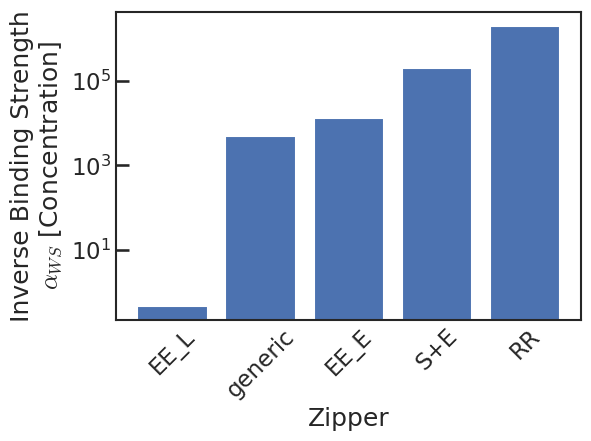

In [4]:

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.bar(df_aff.index, df_aff['mean'], yerr=[df_aff['err_low'], df_aff['err_up']])

ax.set_yscale('log')
ax.set_xlabel("Zipper")
ax.set_ylabel("Inverse Binding Strength\n" + r"$\alpha_{WS}$ [Concentration]")
plt.xticks(rotation=45)

plt.show()

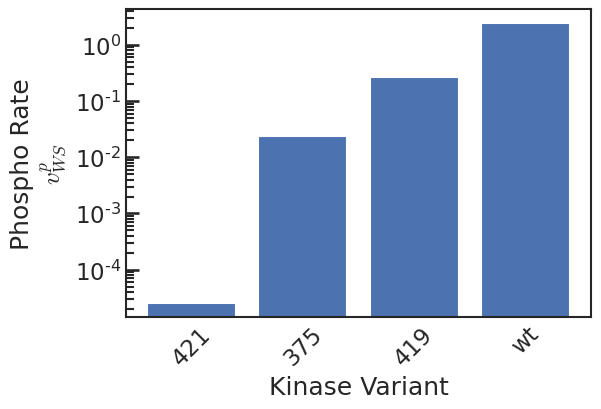

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.bar(df_prate.index, df_prate['mean'], yerr=[df_prate['err_low'], df_prate['err_up']])

ax.set_yscale('log')
ax.set_xlabel("Kinase Variant")
ax.set_ylabel("Phospho Rate\n" + r"$v^p_{WS}$")
plt.xticks(rotation=45)

plt.show()

In [11]:
seed = 42

# load datasets

df_list = []
for index, row in df_avg.reset_index().iterrows():
    df = pd.read_csv("../data/{}_push/{}.csv".format(label, row['dataset'])) 
    
    df = df.drop("Unnamed: 0", axis=1, errors='ignore').reset_index(drop=True)
        
    df['dataset'] = row['dataset'] 
    print(len(df))
    df_list.append(df)
    
# dataframe containing all datasets   
df_data = pd.concat(df_list).drop("Unnamed: 0", axis=1, errors='ignore')
df_data.set_index("dataset", inplace=True, append=True)
df_data = df_data.reorder_levels(df_data.index.names[::-1])
df_data = df_data.rename(columns={'WT_anti': 'WT_anti_exp', 'ST_anti': 'ST_anti_exp', 'SpT_anti': 'SpT_anti_exp', 'Flag : APC - Area': 'WT_anti_exp'})
df_data = df_data[(df_data[df_data.columns[:-1]] > 0).all(axis=1)]
df_data['Sp_frac_anti_exp'] = df_data['SpT_anti_exp'] / df_data['ST_anti_exp']

display(df_data)

21468
21704
19389
21102
18508
21610
20501


WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp
dataset                                                                
375     0      5339.217773   851.042114     41.697887          0.048996
        1      3682.434082  1073.758545     94.396072          0.087912
        2      5771.354492   593.224854     12.720540          0.021443
        3      4066.218262   910.957703    134.919769          0.148108
        4      2823.588623   575.613098    101.300636          0.175987
...                    ...          ...           ...               ...
S+E_250 20496  1468.700684   994.580933    176.785233          0.177748
        20497  1144.411743  1087.729492    189.722549          0.174421
        20498  2770.582031  1080.021118    189.190399          0.175173
        20499  6324.563477  2527.648438    520.051086          0.205745
        20500  5791.209473   722.282104    157.019409          0.217393

[144282 rows x 4 columns]

Num Cells: 17924 Points per bin: 10 Num Bins: 42
Num Cells: 22377 Points per bin: 10 Num Bins: 47


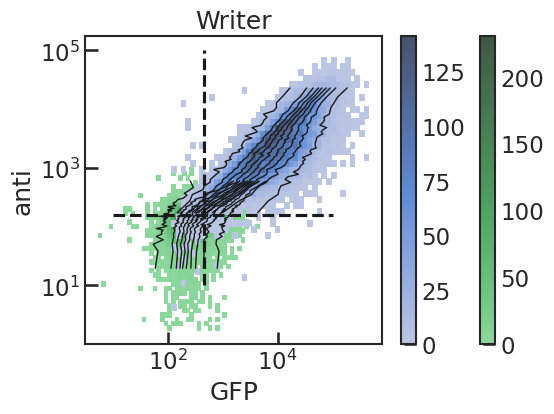

Num Cells: 10802 Points per bin: 10 Num Bins: 32
Num Cells: 22377 Points per bin: 10 Num Bins: 47


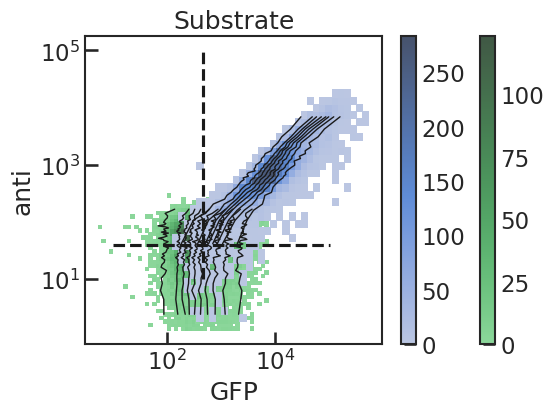

Num Cells: 10802 Points per bin: 10 Num Bins: 32
Num Cells: 22377 Points per bin: 10 Num Bins: 47


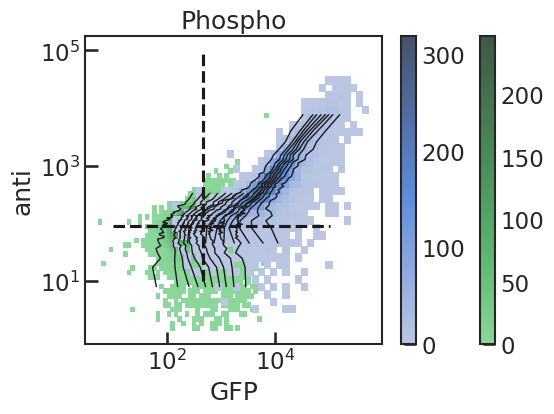

Num Cells: 10802 Points per bin: 10 Num Bins: 32
Num Cells: 33179 Points per bin: 10 Num Bins: 57


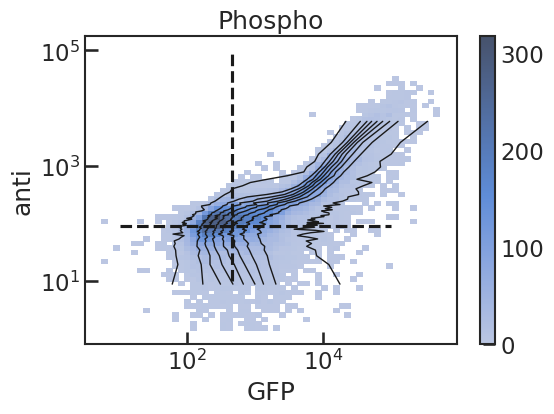

Num Cells: 10802 Points per bin: 10 Num Bins: 32
Num Cells: 22377 Points per bin: 10 Num Bins: 47


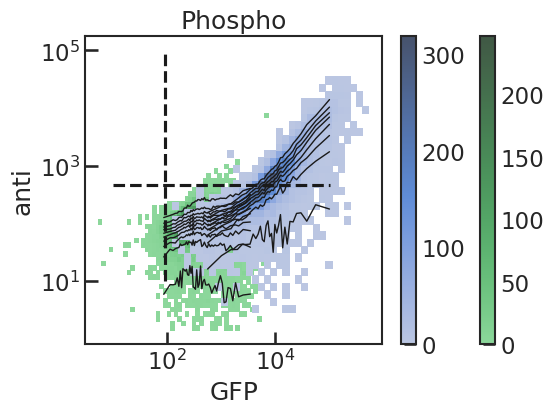

Num Cells: 33179 Points per bin: 10 Num Bins: 57


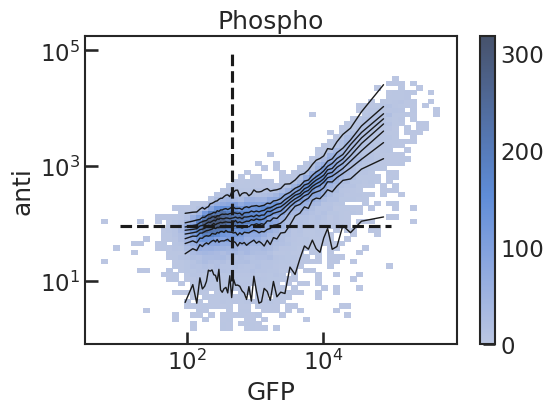

In [11]:
nbins_anti = 100
nbins_GFP = 100

writer_noise = noise.Anti2GFPNoise("../data/{}_noise/Flag noise.csv".format(label), 
                                   flag_label, 'GFP', ppbin=10, verbose=False)

empty_writer_noise = noise.Anti2GFPNoise("../data/{}_noise/Empty Cell.csv".format(label), 
                                   flag_label, 'GFP', ppbin=10, verbose=False)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_writer_noise.plot(ax, color='g')
writer_noise.plot(ax)

ax.set_title("Writer")

ax.hlines(10**np.mean(np.log10(empty_writer_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_writer_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()

    
substrate_noise = noise.Anti2GFPNoise("../data/{}_noise/Myc_Phospho noise.csv".format(label), 
                                   myc_label, 'GFP', ppbin=10, verbose=False)

empty_substrate_noise = noise.Anti2GFPNoise("../data/{}_noise/Empty Cell.csv".format(label), 
                                   myc_label, 'GFP', ppbin=10, verbose=False)



fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_substrate_noise.plot(ax, color='g')
substrate_noise.plot(ax)
ax.set_title("Substrate")

ax.hlines(10**np.mean(np.log10(empty_substrate_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_substrate_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


    
phospho_noise = noise.Anti2GFPNoise("../data/{}_noise/Myc_Phospho noise.csv".format(label), 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)

empty_phospho_noise = noise.Anti2GFPNoise("../data/{}_noise/Empty Cell.csv".format(label), 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

empty_phospho_noise.plot(ax, color='g')
phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


combined_phospho_noise = noise.Anti2GFPNoise("../data/{}_noise/Myc_Phospho noise.csv".format(label), 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)
combined_phospho_noise.add_cells(empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
combined_phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()



inverse_phospho_noise = noise.GFP2AntiNoise("../data/{}_noise/Myc_Phospho noise.csv".format(label), 
                                   'GFP', 'Phospho', ppbin=10, verbose=False)

inverse_empty_phospho_noise = noise.GFP2AntiNoise("../data/{}_noise/Empty Cell.csv".format(label), 
                                   'GFP', 'Phospho', ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

inverse_empty_phospho_noise.plot(ax, color='g')
inverse_phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_GFP())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_anti())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()



inverse_phospho_noise.add_cells(inverse_empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
inverse_phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()



In [13]:

for index, row in df_avg.reset_index().iterrows():
    
    dataset = row['dataset']
    
    print(dataset)
    
    df_tmp = df_data.query("dataset==@dataset")
    
    ################################################################
    
    
    writer_empty_frac = row['WT_empty_frac']
    writer_anti_scale = row['WT_anti_scale']
   
    df_data.loc[df_tmp.index, 'WT_anti_rescaled'] = df_tmp['WT_anti_exp'] / 10**writer_anti_scale
        
        
    df_data.loc[df_tmp.index, 'WT_prob_empty'] = noise.calc_prob_empty(df_data.loc[df_tmp.index, 'WT_anti_rescaled'], 
                                                                 writer_empty_frac, 
                                                                 empty_writer_noise, writer_noise)
    
    
    ################################################################

    
    substrate_empty_frac = row['ST_empty_frac']
    substrate_anti_scale = row['ST_anti_scale']
 
            
    df_data.loc[df_tmp.index, 'ST_anti_rescaled'] = df_tmp['ST_anti_exp'] / 10**substrate_anti_scale
    
        
    df_data.loc[df_tmp.index, 'ST_prob_empty'] = noise.calc_prob_empty(df_data.loc[df_tmp.index, 'ST_anti_rescaled'], 
                                                                 substrate_empty_frac, 
                                                                 empty_substrate_noise, substrate_noise)
    

375
419
421_1000
E_250
L_250
RR_250
S+E_250


In [14]:
# convert antibody values to inferred GFP values using noise models

zero = 0.0

for index, row in df_avg.reset_index().iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df_data.query("dataset==@dataset")
    
    # convert antibody measurements to GFP measurements
    GFP_infer, anti_bin, GFP_bin = writer_noise.anti_to_GFP(df_data.loc[df_tmp.index, 'WT_anti_rescaled'])
    df_data.loc[df_tmp.index, 'WT_GFP_infer'] = GFP_infer
#     df_data.loc[df_tmp.index, 'WT_anti_bin'] = anti_bin
#     df_data.loc[df_tmp.index, 'WT_GFP_bin'] = GFP_bin
    df_data.loc[df_tmp.index, 'WT_conc_infer'] = np.maximum(df_data.loc[df_tmp.index, 'WT_GFP_infer'] - np.median(empty_writer_noise.get_GFP()), zero)

    GFP_infer, anti_bin, GFP_bin = substrate_noise.anti_to_GFP(df_data.loc[df_tmp.index, 'ST_anti_rescaled'])
    df_data.loc[df_tmp.index, 'ST_GFP_infer'] = GFP_infer
#     df_data.loc[df_tmp.index, 'ST_anti_bin'] = anti_bin
#     df_data.loc[df_tmp.index, 'ST_GFP_bin'] = GFP_bin
    df_data.loc[df_tmp.index, 'ST_conc_infer'] = np.maximum(df_data.loc[df_tmp.index, 'ST_GFP_infer'] - np.median(empty_substrate_noise.get_GFP()), zero)

    
    GFP_infer, anti_bin, GFP_bin = combined_phospho_noise.anti_to_GFP(df_data.loc[df_tmp.index, 'SpT_anti_exp'])
    df_data.loc[df_tmp.index, 'SpT_GFP_infer'] = GFP_infer
#     df_data.loc[df_tmp.index, 'SpT_anti_bin'] = anti_bin
#     df_data.loc[df_tmp.index, 'SpT_GFP_bin'] = GFP_bin
    df_data.loc[df_tmp.index, 'SpT_conc_infer'] = np.maximum(df_data.loc[df_tmp.index, 'SpT_GFP_infer'] - np.median(empty_phospho_noise.get_GFP()), zero)

    df_data.loc[df_tmp.index, 'Sp_frac_GFP_infer'] = df_data.loc[df_tmp.index, 'SpT_GFP_infer'] / df_data.loc[df_tmp.index, 'ST_GFP_infer']
    df_data.loc[df_tmp.index, 'Sp_frac_conc_infer'] = df_data.loc[df_tmp.index, 'SpT_conc_infer'] / df_data.loc[df_tmp.index, 'ST_conc_infer']
    
    
    df_data.loc[df_tmp.index, 'total_prob_empty'] = 1.0  - (1-df_data.loc[df_tmp.index, 'ST_prob_empty'])*(1-df_data.loc[df_tmp.index, 'WT_prob_empty'])
    
    
    
display(df_data)
print(len(df_data))
print(len(df_data.dropna()))


WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp  \
dataset                                                                   
375     0      5339.217773   851.042114     41.697887          0.048996   
        1      3682.434082  1073.758545     94.396072          0.087912   
        2      5771.354492   593.224854     12.720540          0.021443   
        3      4066.218262   910.957703    134.919769          0.148108   
        4      2823.588623   575.613098    101.300636          0.175987   
...                    ...          ...           ...               ...   
S+E_250 20496  1468.700684   994.580933    176.785233          0.177748   
        20497  1144.411743  1087.729492    189.722549          0.174421   
        20498  2770.582031  1080.021118    189.190399          0.175173   
        20499  6324.563477  2527.648438    520.051086          0.205745   
        20500  5791.209473   722.282104    157.019409          0.217393   

               WT_anti_rescaled  WT_prob_empty  ST_anti_rescaled  \
dataset                                                            
375     0           5339.217773            0.0        851.042114   
        1           3682.434082            0.0       1073.758545   
        2           5771.354492            0.0        593.224854   
        3           4066.218262            0.0        910.957703   
        4           2823.588623            0.0        575.613098   
...                         ...            ...               ...   
S+E_250 20496       1468.700684            0.0        994.580933   
        20497       1144.411743            0.0       1087.729492   
        20498       2770.582031            0.0       1080.021118   
        20499       6324.563477            0.0       2527.648438   
        20500       5791.209473            0.0        722.282104   

               ST_prob_empty  WT_GFP_infer  WT_conc_infer  ST_GFP_infer  \
dataset                                                                   
375     0                0.0   7861.662353    7443.618164  10348.317380   
        1                0.0  28001.206055   27583.161866   8324.061524   
        2                0.0  11851.349120   11433.304931  12183.337890   
        3                0.0  20295.072265   19877.028076  13749.760745   
        4                0.0  25420.332030   25002.287841   5412.303223   
...                      ...           ...            ...           ...   
S+E_250 20496            0.0   7986.296387    7568.252198  11509.839840   
        20497            0.0   3336.025513    2917.981324   7993.448242   
        20498            0.0  13322.810550   12904.766361   6967.762940   
        20499            0.0  10784.784670   10366.740481  51648.417970   
        20500            0.0  18639.562500   18221.518311  20727.474610   

               ST_conc_infer  SpT_GFP_infer  SpT_conc_infer  \
dataset                                                       
375     0        9930.273191     138.296074        0.000000   
        1        7906.017335     177.889938        0.000000   
        2       11765.293701     670.259399      252.215210   
        3       13331.716556    1010.559814      592.515625   
        4        4994.259034     510.649155       92.604965   
...                      ...            ...             ...   
S+E_250 20496   11091.795651     328.503387        0.000000   
        20497    7575.404053     322.728653        0.000000   
        20498    6549.718751    4366.583741     3948.539552   
        20499   51230.373781    7107.250488     6689.206299   
        20500   20309.430421     251.343315        0.000000   

               Sp_frac_GFP_infer  Sp_frac_conc_infer  total_prob_empty  
dataset                                                                 
375     0               0.013364            0.000000               0.0  
        1               0.021371            0.000000               0.0  
        2               0.055014            0.021437              

144282
142986


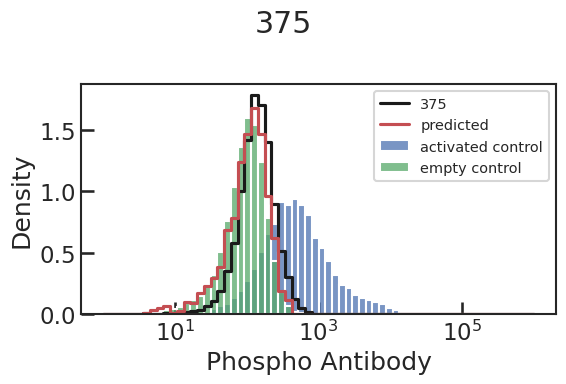

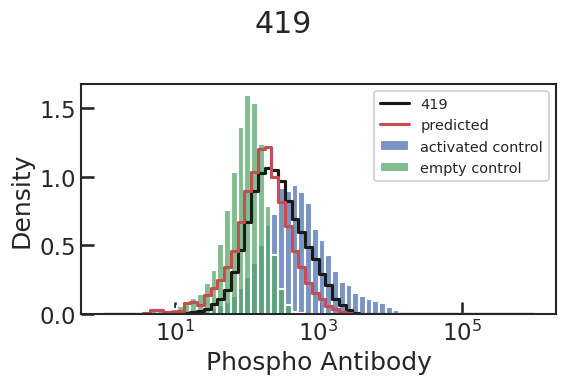

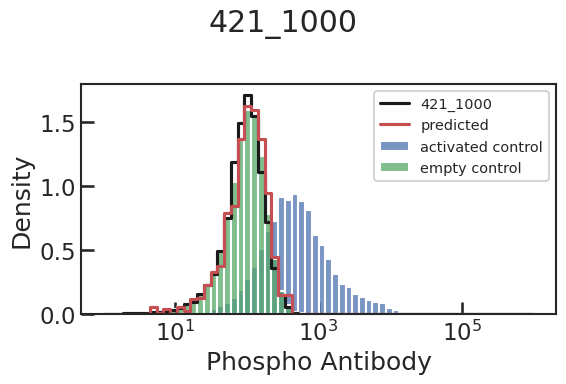

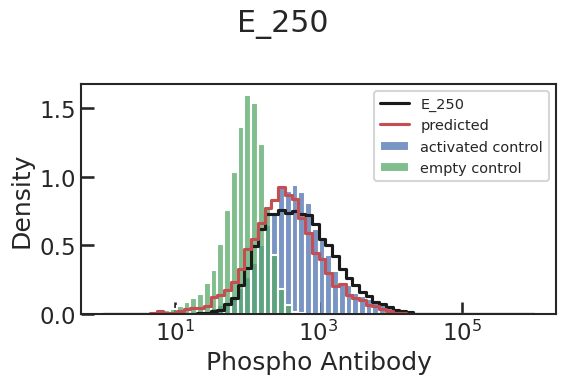

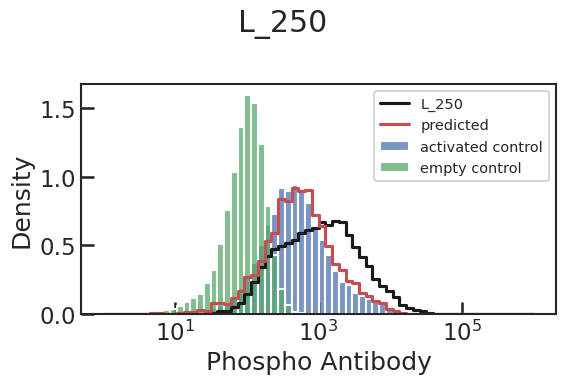

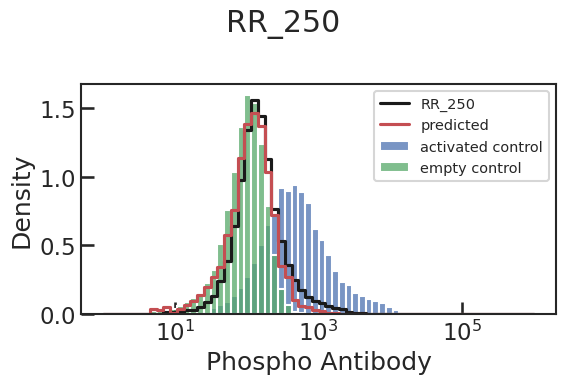

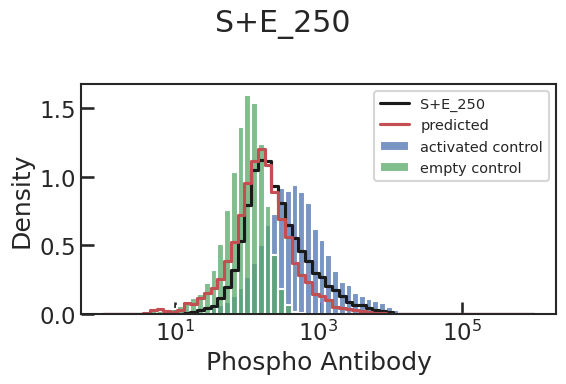

In [15]:
binrange = (0, 6)

for index, row in df_avg.reset_index().iterrows():
    
    dataset = row['dataset']
    
    # need to dropna, but filler for new column is also nan, need to initialize beforehand
    
    df_tmp = df_data.dropna(subset=['ST_GFP_infer', 'WT_GFP_infer', 'SpT_GFP_infer']).query("dataset==@dataset").copy()  
        
    model_params = np.array([row['bg_phospho_rate'], 
                             row['kinase_phospho_rate'], 
                             row['kinase_bind_affin']])
    
    df_data.loc[df_tmp.index, 'SpT_conc_predict'] = pp.PushAmp().predict_all(df_tmp[['WT_conc_infer', 'ST_conc_infer']].values, model_params)[:, 0]
    df_data.loc[df_tmp.index, 'SpT_GFP_predict'] = df_data.loc[df_tmp.index, 'SpT_conc_predict'] + np.median(empty_phospho_noise.get_GFP())
    
    df_data.loc[df_tmp.index, 'Sp_frac_GFP_predict'] = df_data.loc[df_tmp.index, 'SpT_GFP_predict'] / df_tmp['ST_GFP_infer']

    
    anti, GFP_bins, anti_bins = inverse_phospho_noise.GFP_to_anti(df_data.loc[df_tmp.index, 'SpT_GFP_predict'])
    
    df_data.loc[df_tmp.index, 'SpT_anti_predict'] = anti
    
    df_data.loc[df_tmp.index, 'Sp_frac_conc_predict'] = df_data.loc[df_tmp.index, 'SpT_conc_predict'] / df_tmp['ST_conc_infer']
    
    df_data.loc[df_tmp.index, 'Sp_frac_anti_predict'] = df_data.loc[df_tmp.index, 'SpT_anti_predict'] / df_data.loc[df_tmp.index, 'ST_anti_exp']
    
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    
    fig.suptitle(dataset)

    
    ax = axes
    
    sns.histplot(df_data.loc[df_tmp.index, 'SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(df_data.loc[df_tmp.index, 'SpT_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='activated control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()
        

In [74]:
with open('/projectnb/biophys/jrocks/proj_push_pull/data/dfnomixture_{}.pkl'.format(label), 'wb') as pkl_file:
    
    data = {'df': df_data}
    pickle.dump(data, pkl_file)
    
display(df_data)

WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp  \
dataset                                                                   
375     0      5339.217773   851.042114     41.697887          0.048996   
        1      3682.434082  1073.758545     94.396072          0.087912   
        2      5771.354492   593.224854     12.720540          0.021443   
        3      4066.218262   910.957703    134.919769          0.148108   
        4      2823.588623   575.613098    101.300636          0.175987   
...                    ...          ...           ...               ...   
S+E_250 20496  1468.700684   994.580933    176.785233          0.177748   
        20497  1144.411743  1087.729492    189.722549          0.174421   
        20498  2770.582031  1080.021118    189.190399          0.175173   
        20499  6324.563477  2527.648438    520.051086          0.205745   
        20500  5791.209473   722.282104    157.019409          0.217393   

               WT_anti_rescaled  WT_prob_empty  ST_anti_rescaled  \
dataset                                                            
375     0           5339.217773            0.0        851.042114   
        1           3682.434082            0.0       1073.758545   
        2           5771.354492            0.0        593.224854   
        3           4066.218262            0.0        910.957703   
        4           2823.588623            0.0        575.613098   
...                         ...            ...               ...   
S+E_250 20496       1468.700684            0.0        994.580933   
        20497       1144.411743            0.0       1087.729492   
        20498       2770.582031            0.0       1080.021118   
        20499       6324.563477            0.0       2527.648438   
        20500       5791.209473            0.0        722.282104   

               ST_prob_empty  WT_GFP_infer  WT_conc_infer  ...  \
dataset                                                    ...   
375     0                0.0  19184.554690   18766.510501  ...   
        1                0.0  66535.871095   66117.826906  ...   
        2                0.0  21989.698240   21571.654051  ...   
        3                0.0  17224.664065   16806.619876  ...   
        4                0.0   5214.514160    4796.469971  ...   
...                      ...           ...            ...  ...   
S+E_250 20496            0.0   7539.721191    7121.677002  ...   
        20497            0.0  21415.855470   20997.811281  ...   
        20498            0.0  10592.990235   10174.946046  ...   
        20499            0.0  26717.626950   26299.582761  ...   
        20500            0.0  19903.476560   19485.432371  ...   

               SpT_conc_infer  Sp_frac_GFP_infer  Sp_frac_conc_infer  \
dataset                                                                
375     0            0.000000           0.012457            0.000000   
        1          576.939148           0.106804            0.064840   
        2          252.215210           0.102074            0.041022   
        3            0.000000           0.019294            0.000000   
        4            0.000000           0.059962            0.000000   
...                       ...                ...                 ...   
S+E_250 20496      458.564606           0.105642            0.058194   
        20497     1477.046998           0.245132            0.201980   
        20498      891.041078           0.124045            0.087915   
        20499    15263.396241           0.928137            0.926314   
        20500     1317.383790           0.099563            0.077437   

               total_prob_empty  SpT_conc_predict  SpT_GFP_predict  \
dataset                                                              
375     0                   0.0        264.000296       682.044485   
        1                   0.0        213.374346       631.418535   
        2                   0.0        129.760644       547.804833   
        

In [12]:
with open('/projectnb/biophys/jrocks/proj_push_pull/data/dfnomixture_{}.pkl'.format(label), 'rb') as pkl_file:
    
    data = pickle.load(pkl_file)
    df_data = data['df']
    
display(df_data)

WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp  \
dataset                                                                   
375     0      5339.217773   851.042114     41.697887          0.048996   
        1      3682.434082  1073.758545     94.396072          0.087912   
        2      5771.354492   593.224854     12.720540          0.021443   
        3      4066.218262   910.957703    134.919769          0.148108   
        4      2823.588623   575.613098    101.300636          0.175987   
...                    ...          ...           ...               ...   
S+E_250 20496  1468.700684   994.580933    176.785233          0.177748   
        20497  1144.411743  1087.729492    189.722549          0.174421   
        20498  2770.582031  1080.021118    189.190399          0.175173   
        20499  6324.563477  2527.648438    520.051086          0.205745   
        20500  5791.209473   722.282104    157.019409          0.217393   

               WT_anti_rescaled  WT_prob_empty  ST_anti_rescaled  \
dataset                                                            
375     0           5339.217773            0.0        851.042114   
        1           3682.434082            0.0       1073.758545   
        2           5771.354492            0.0        593.224854   
        3           4066.218262            0.0        910.957703   
        4           2823.588623            0.0        575.613098   
...                         ...            ...               ...   
S+E_250 20496       1468.700684            0.0        994.580933   
        20497       1144.411743            0.0       1087.729492   
        20498       2770.582031            0.0       1080.021118   
        20499       6324.563477            0.0       2527.648438   
        20500       5791.209473            0.0        722.282104   

               ST_prob_empty  WT_GFP_infer  WT_conc_infer  ...  \
dataset                                                    ...   
375     0                0.0  11832.453130   11414.408941  ...   
        1                0.0   8018.317627    7600.273438  ...   
        2                0.0   7560.187256    7142.143067  ...   
        3                0.0   7907.320069    7489.275879  ...   
        4                0.0  81396.515630   80978.471441  ...   
...                      ...           ...            ...  ...   
S+E_250 20496            0.0   8434.464356    8016.420167  ...   
        20497            0.0   1955.253540    1537.209351  ...   
        20498            0.0   5596.238769    5178.194580  ...   
        20499            0.0  32464.360350   32046.316161  ...   
        20500            0.0  10203.207030    9785.162841  ...   

               SpT_conc_infer  Sp_frac_GFP_infer  Sp_frac_conc_infer  \
dataset                                                                
375     0            0.000000           0.025776            0.000000   
        1            0.000000           0.014525            0.000000   
        2            0.000000           0.033443            0.000000   
        3         1071.156922           0.160927            0.121229   
        4            0.000000           0.036123            0.000000   
...                       ...                ...                 ...   
S+E_250 20496     1081.261475           0.153132            0.115360   
        20497     2658.537232           0.206895            0.183954   
        20498     2009.377930           0.253354            0.219290   
        20499     6935.249268           0.421106            0.406907   
        20500     2609.271607           0.610517            0.574658   

               total_prob_empty  SpT_conc_predict  SpT_GFP_predict  \
dataset                                                              
375     0                   0.0        188.415670       606.459859   
        1                   0.0        116.336469       534.380658   
        2                   0.0         57.405487       475.449676   
        

In [7]:
# df_data.to_excel("push_210728.xlsx")

df_data.to_csv("push_210728.csv")

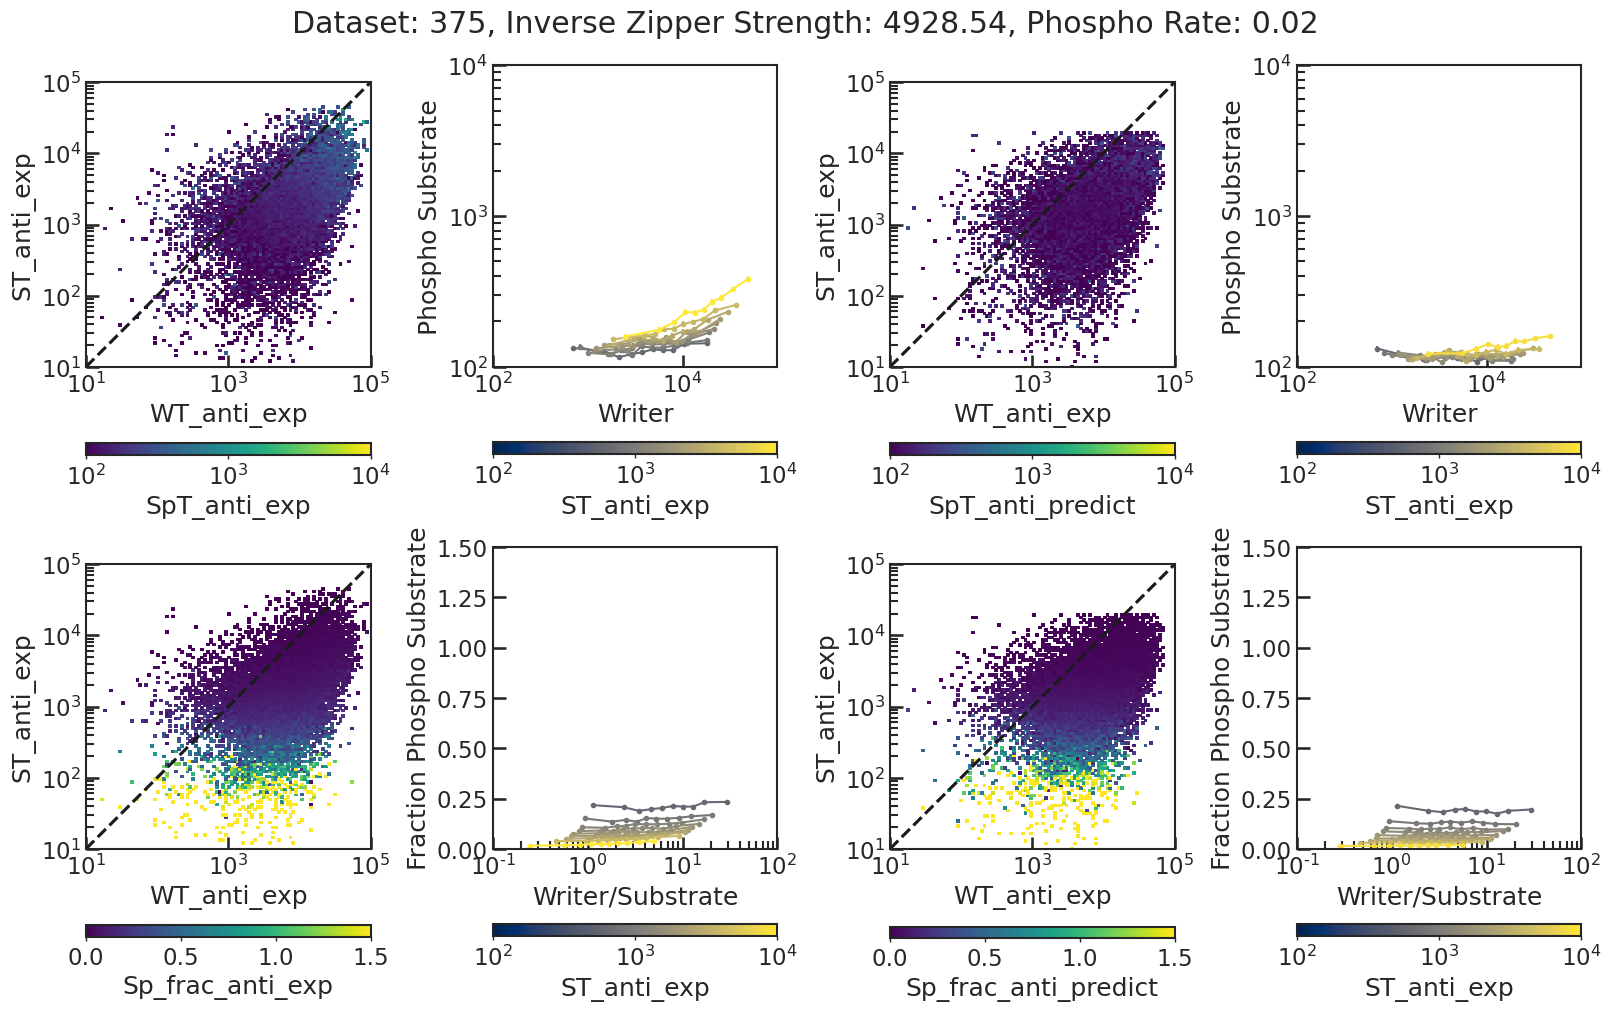

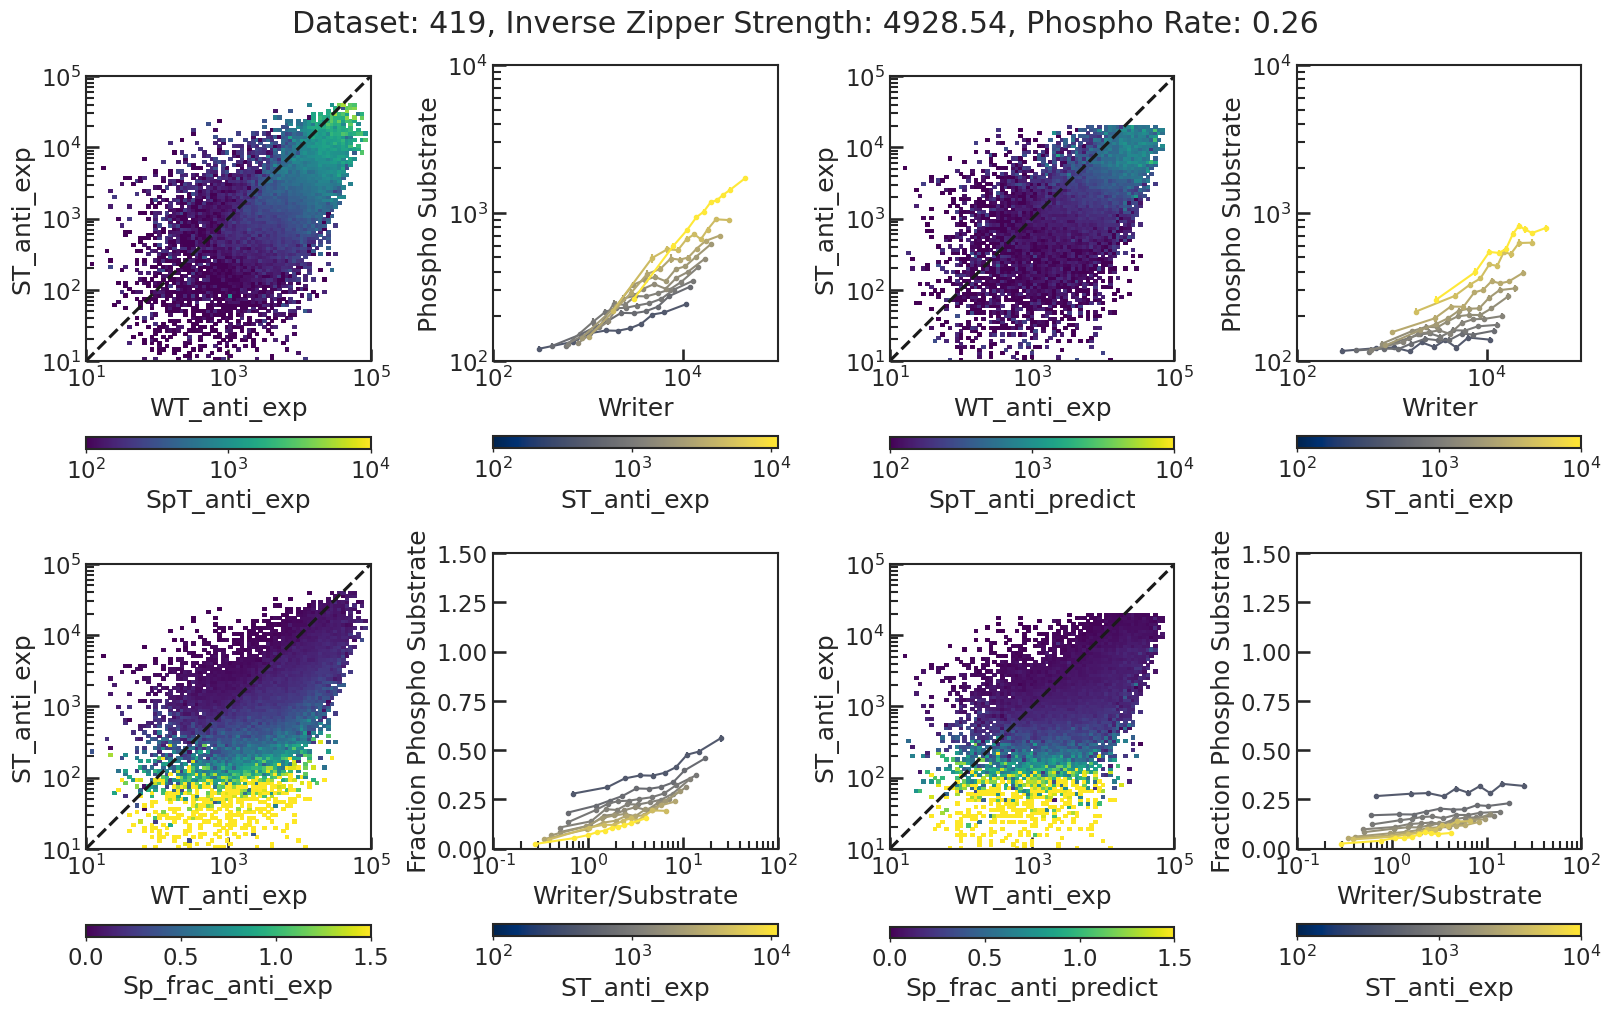

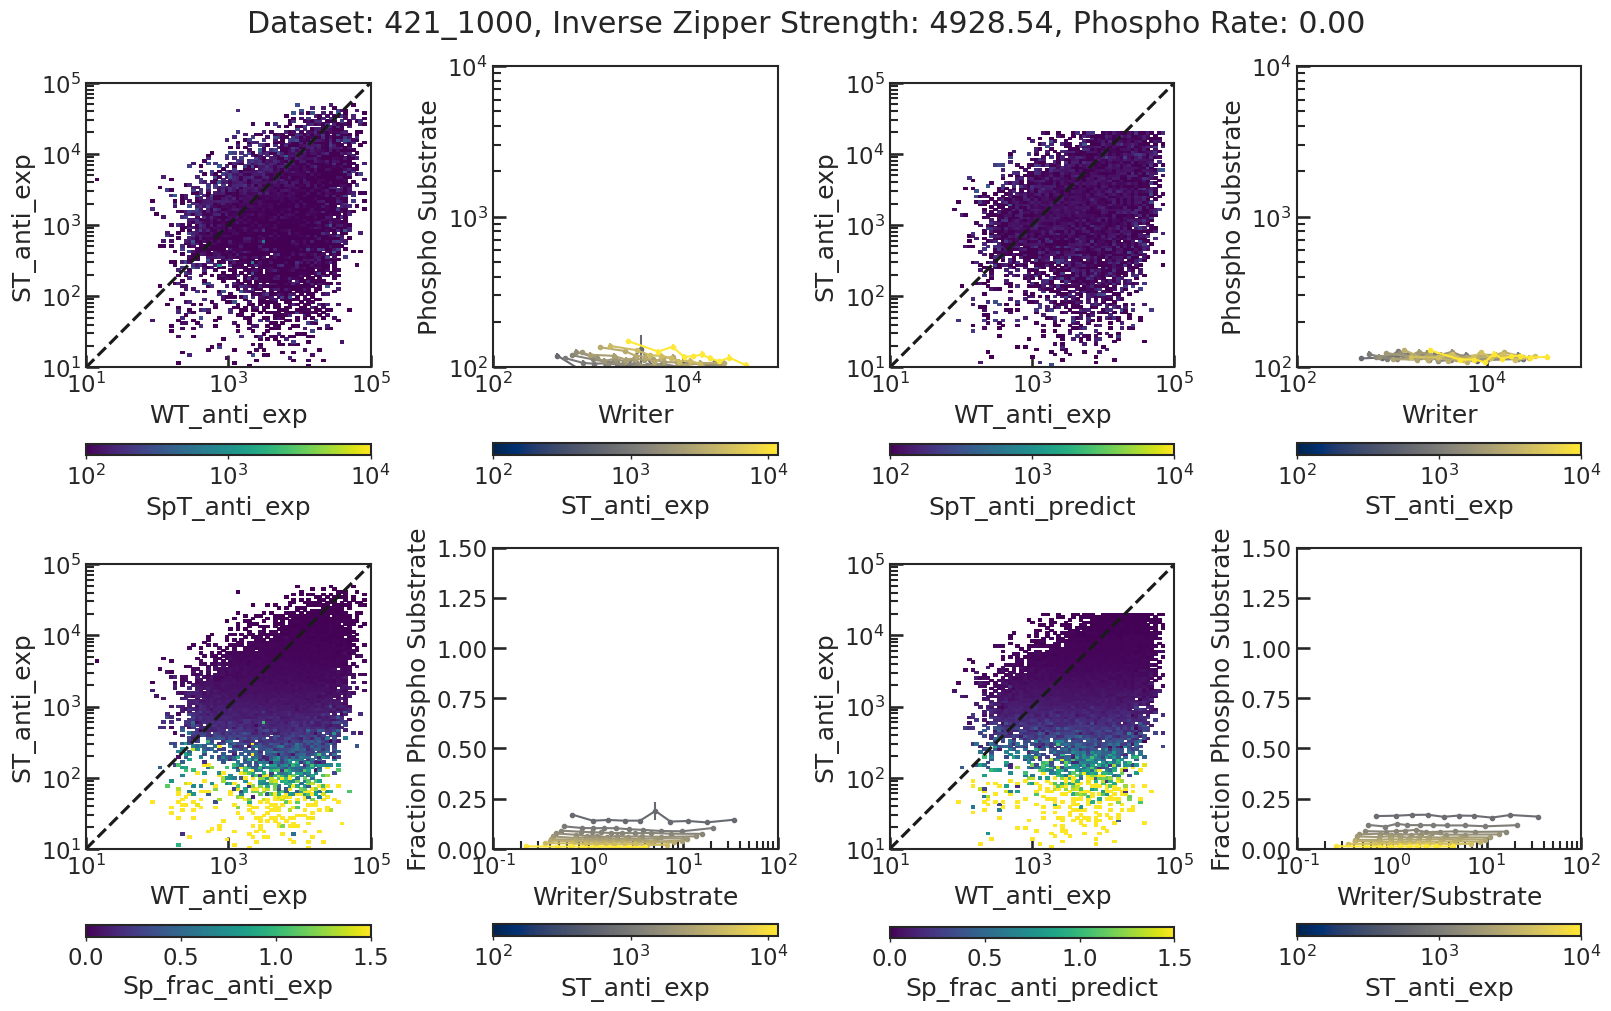

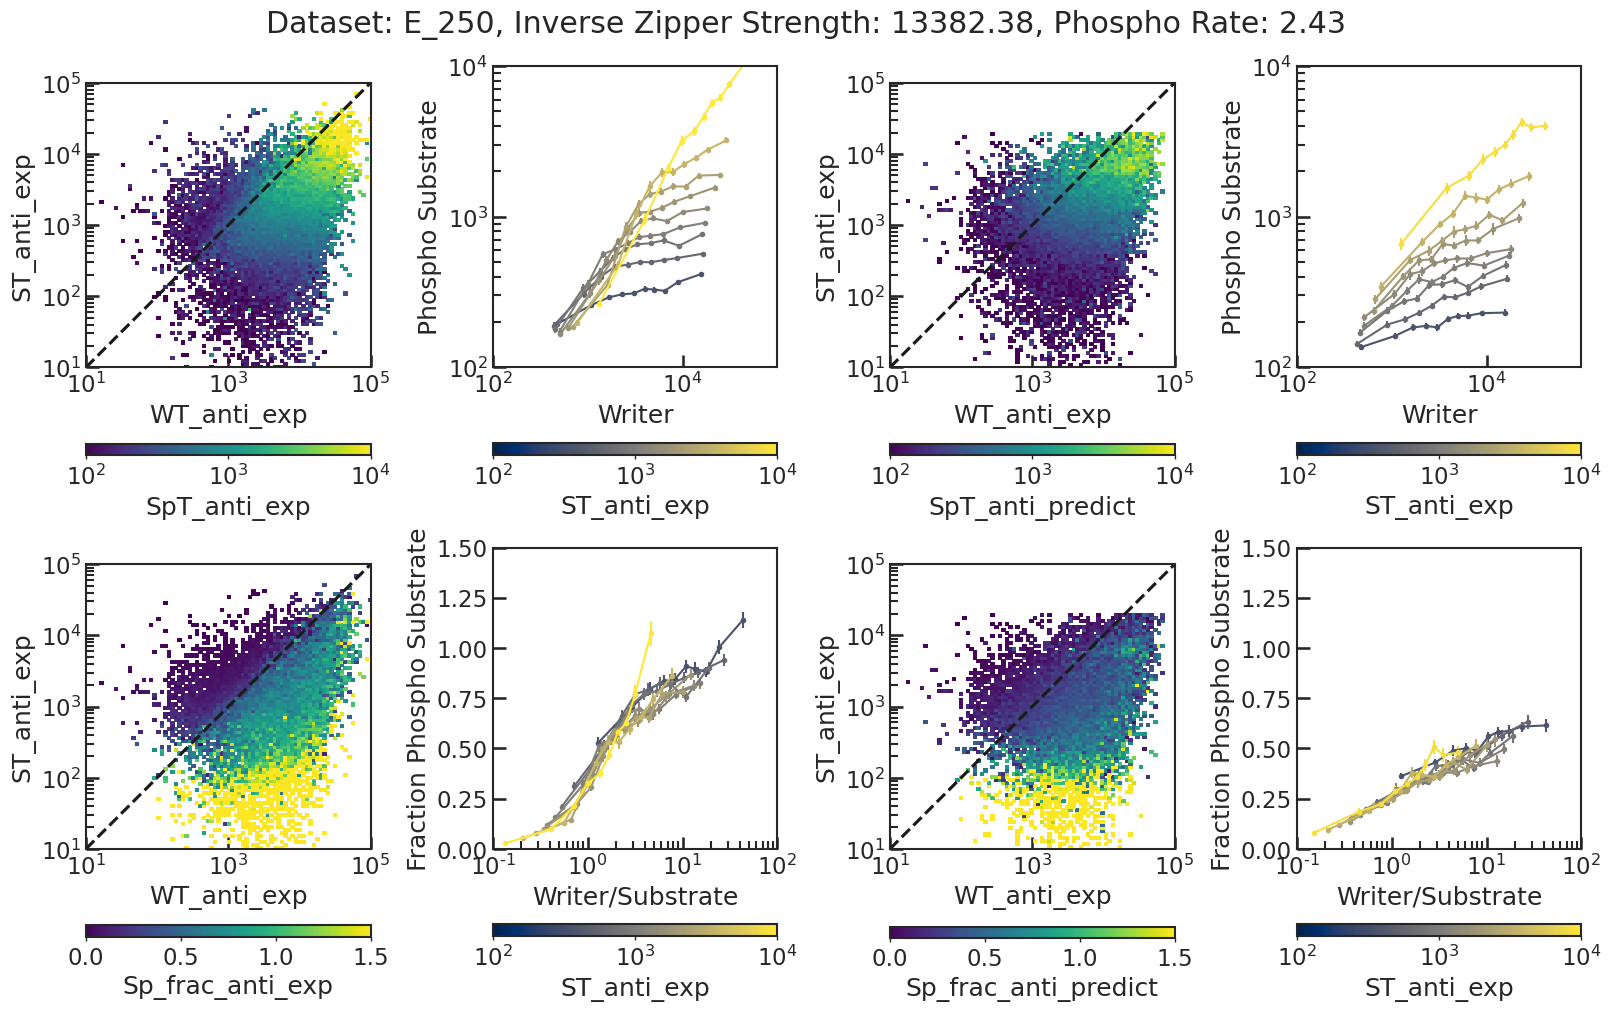

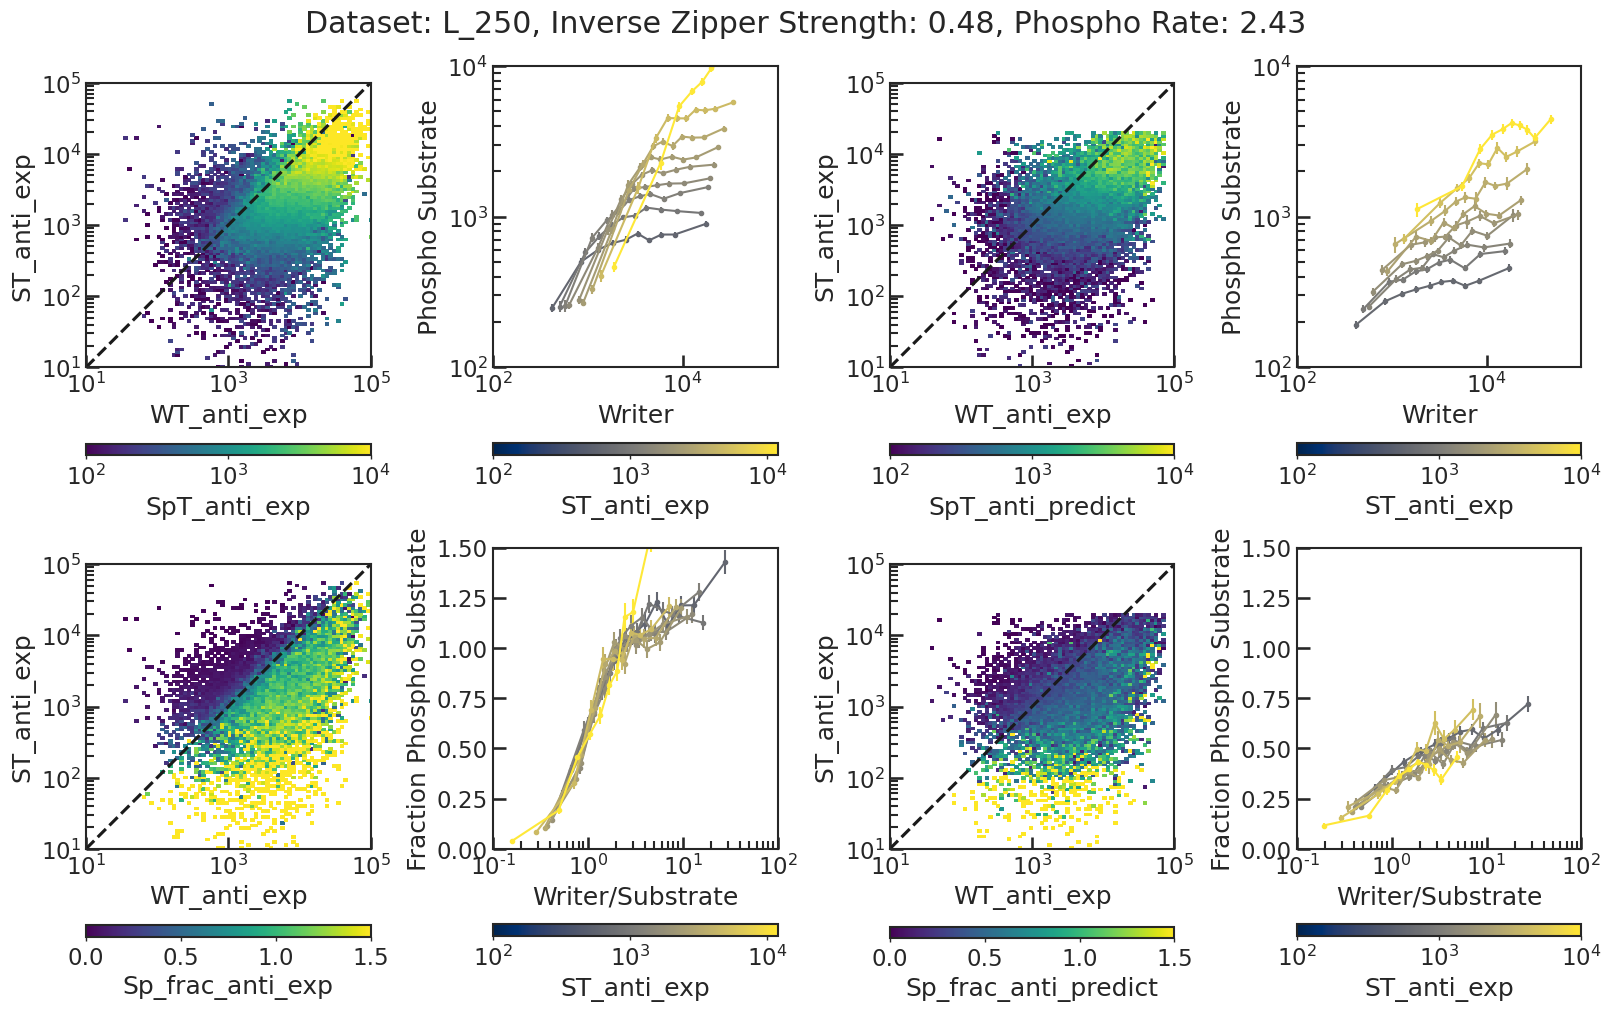

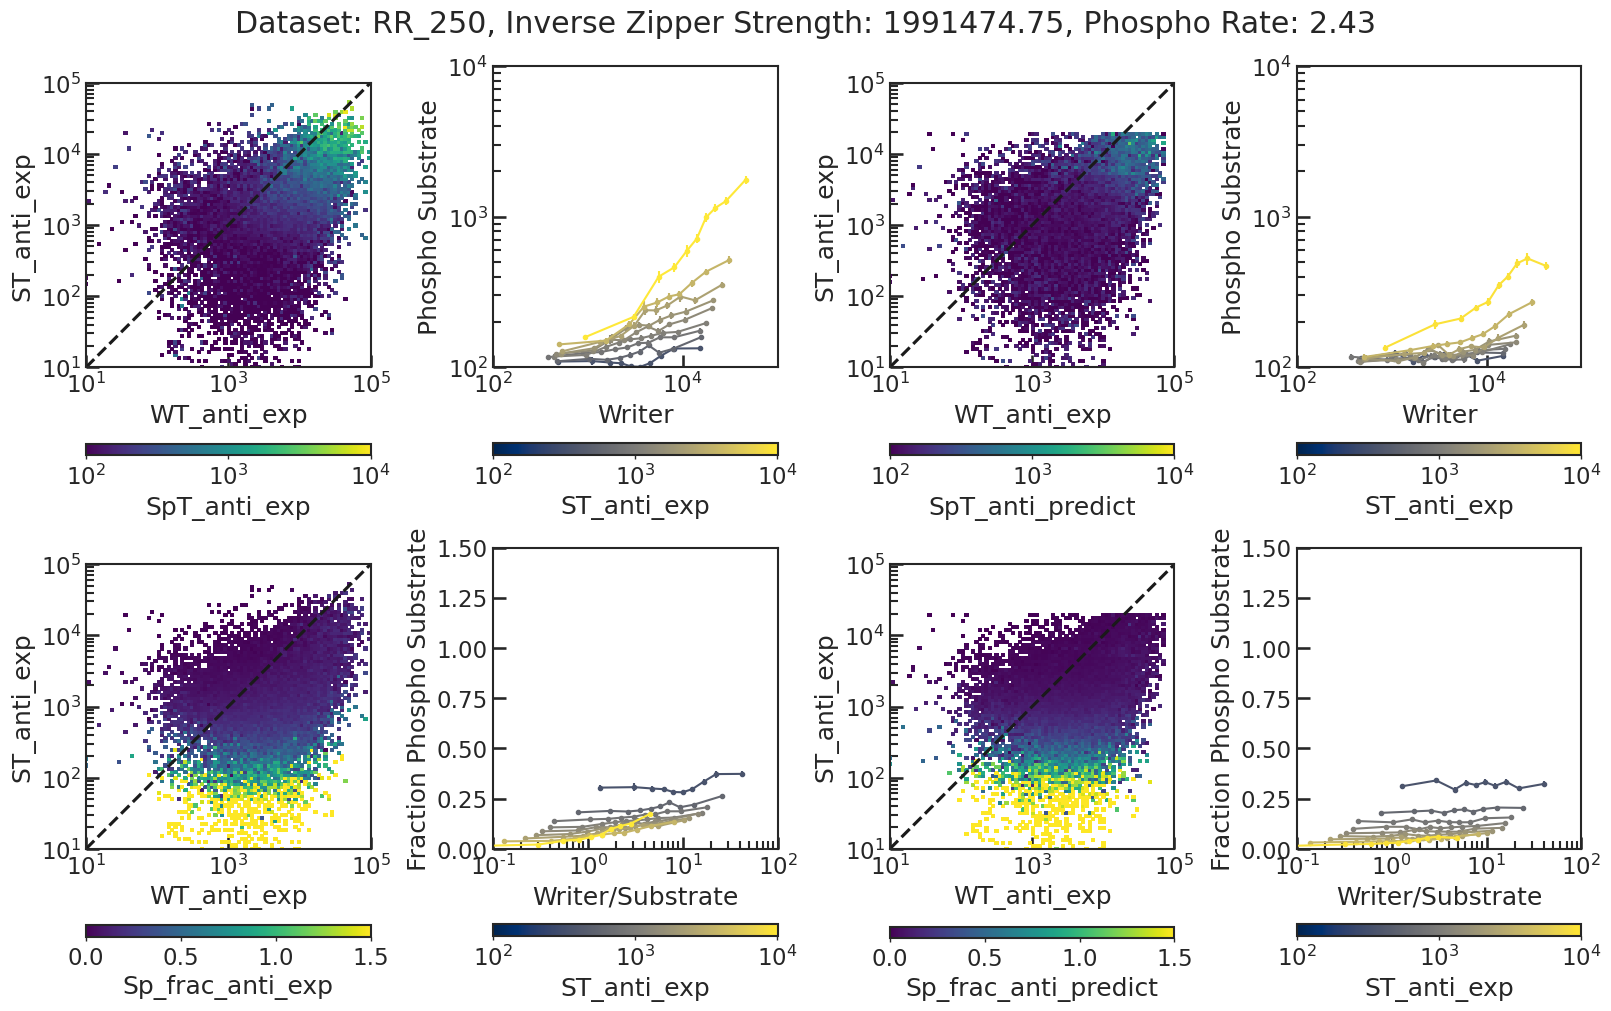

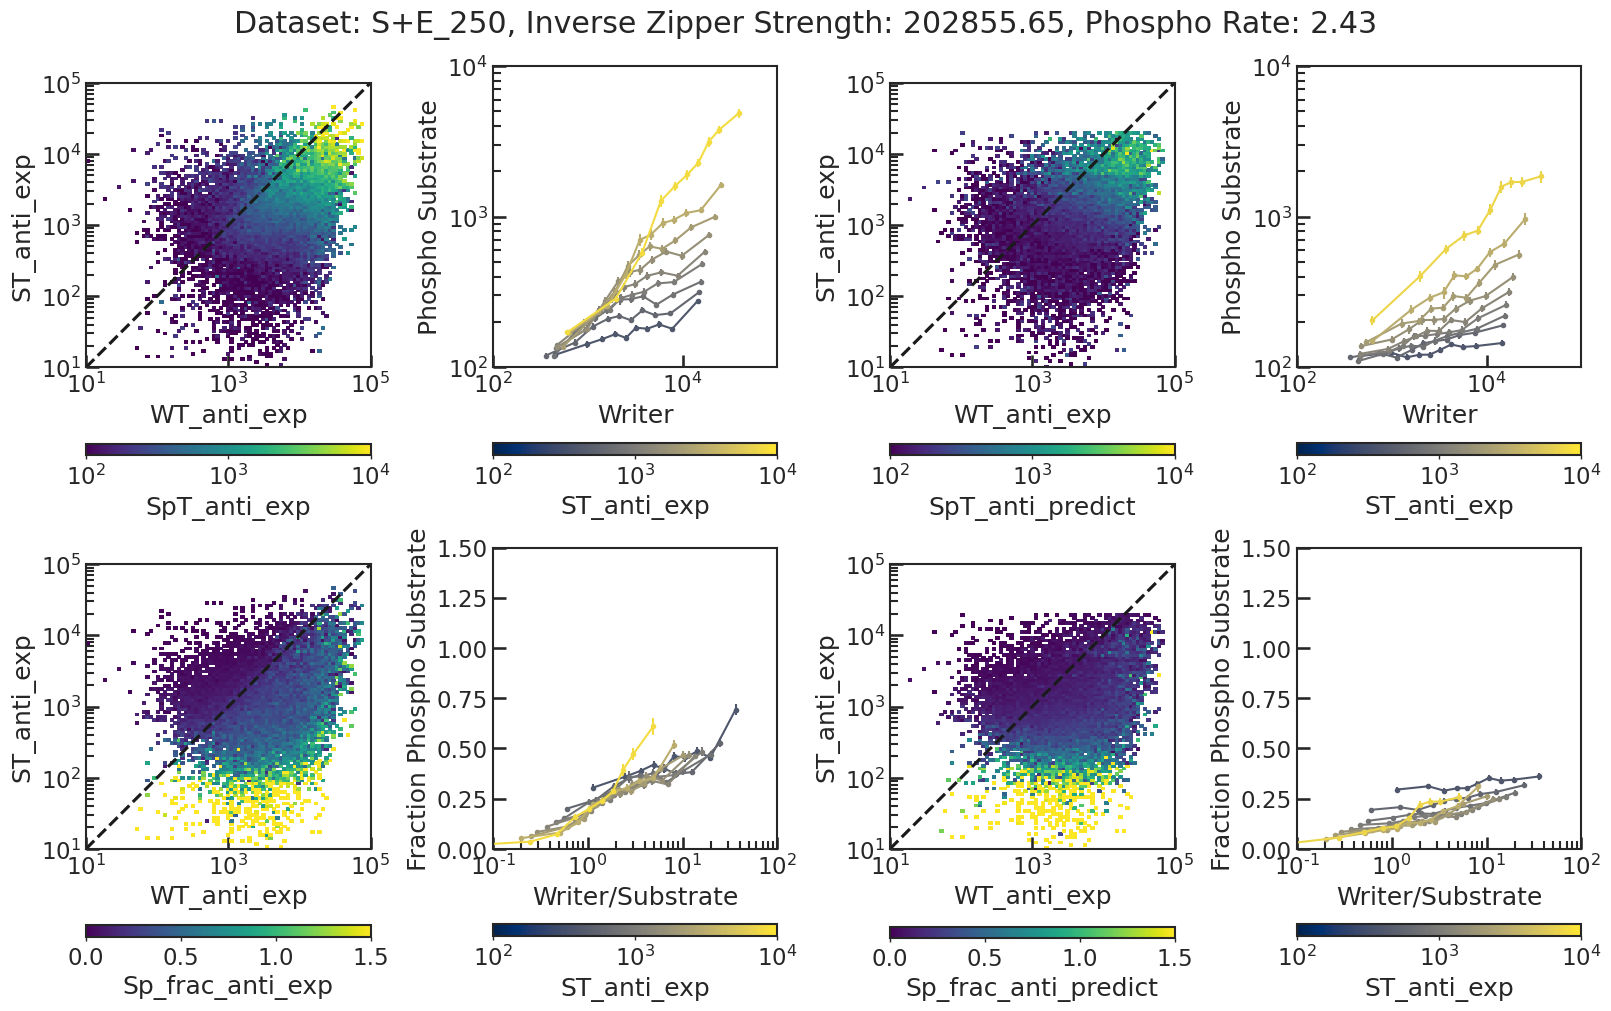

In [8]:
for index, row in df_avg.reset_index().iterrows():

    dataset = row['dataset']
    
    df_tmp = df_data.query("dataset==@dataset").copy()

    fig = plt.figure(constrained_layout=True, figsize=(16, 10))
    
    gs = fig.add_gridspec(2, 4)

    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_exp', logscale=True, vmin=1e2, vmax=1e4)
    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 1])
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 
                                 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_exp', normalizex=False, normalizey=False)
    
    
    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 2])
    
    fplot.plot_2d_avg(df_tmp.dropna().copy(), fig, ax, 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_predict', logscale=True, vmin=1e2, vmax=1e4)
    
    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 3])
    
    fplot.plot_activation_curves(df_tmp.dropna().copy(), fig, ax, 
                                 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_predict', normalizex=False, normalizey=False)

    
    ##########################################################
    
    
    ax = fig.add_subplot(gs[1, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 'WT_anti_exp', 'ST_anti_exp', 'Sp_frac_anti_exp', logscale=False, vmin=0.0, vmax=1.5)
    
    
    ############################################################
    
    
    ax = fig.add_subplot(gs[1, 1])
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 
                                 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_exp', normalizex=True, normalizey=True, xlim=(1e-1, 1e2), ylim=(0, 1.5))
    
    
    ############################################################
    
    ax = fig.add_subplot(gs[1, 2])
    
    fplot.plot_2d_avg(df_tmp.dropna().copy(), fig, ax, 'WT_anti_exp', 'ST_anti_exp', 'Sp_frac_anti_predict', logscale=False, vmin=0.0, vmax=1.5)
    
    
    ############################################################
    
    ax = fig.add_subplot(gs[1, 3])
    
    fplot.plot_activation_curves(df_tmp.dropna().copy(), fig, ax, 
                                 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_predict', normalizex=True, normalizey=True, xlim=(1e-1, 1e2), ylim=(0, 1.5))
    
    ##########################################################

    fig.suptitle("Dataset: {0}, Inverse Zipper Strength: {1:.2f}, Phospho Rate: {2:.2f}".format(dataset, row['kinase_bind_affin'], row['kinase_phospho_rate']))

    plt.show()
    

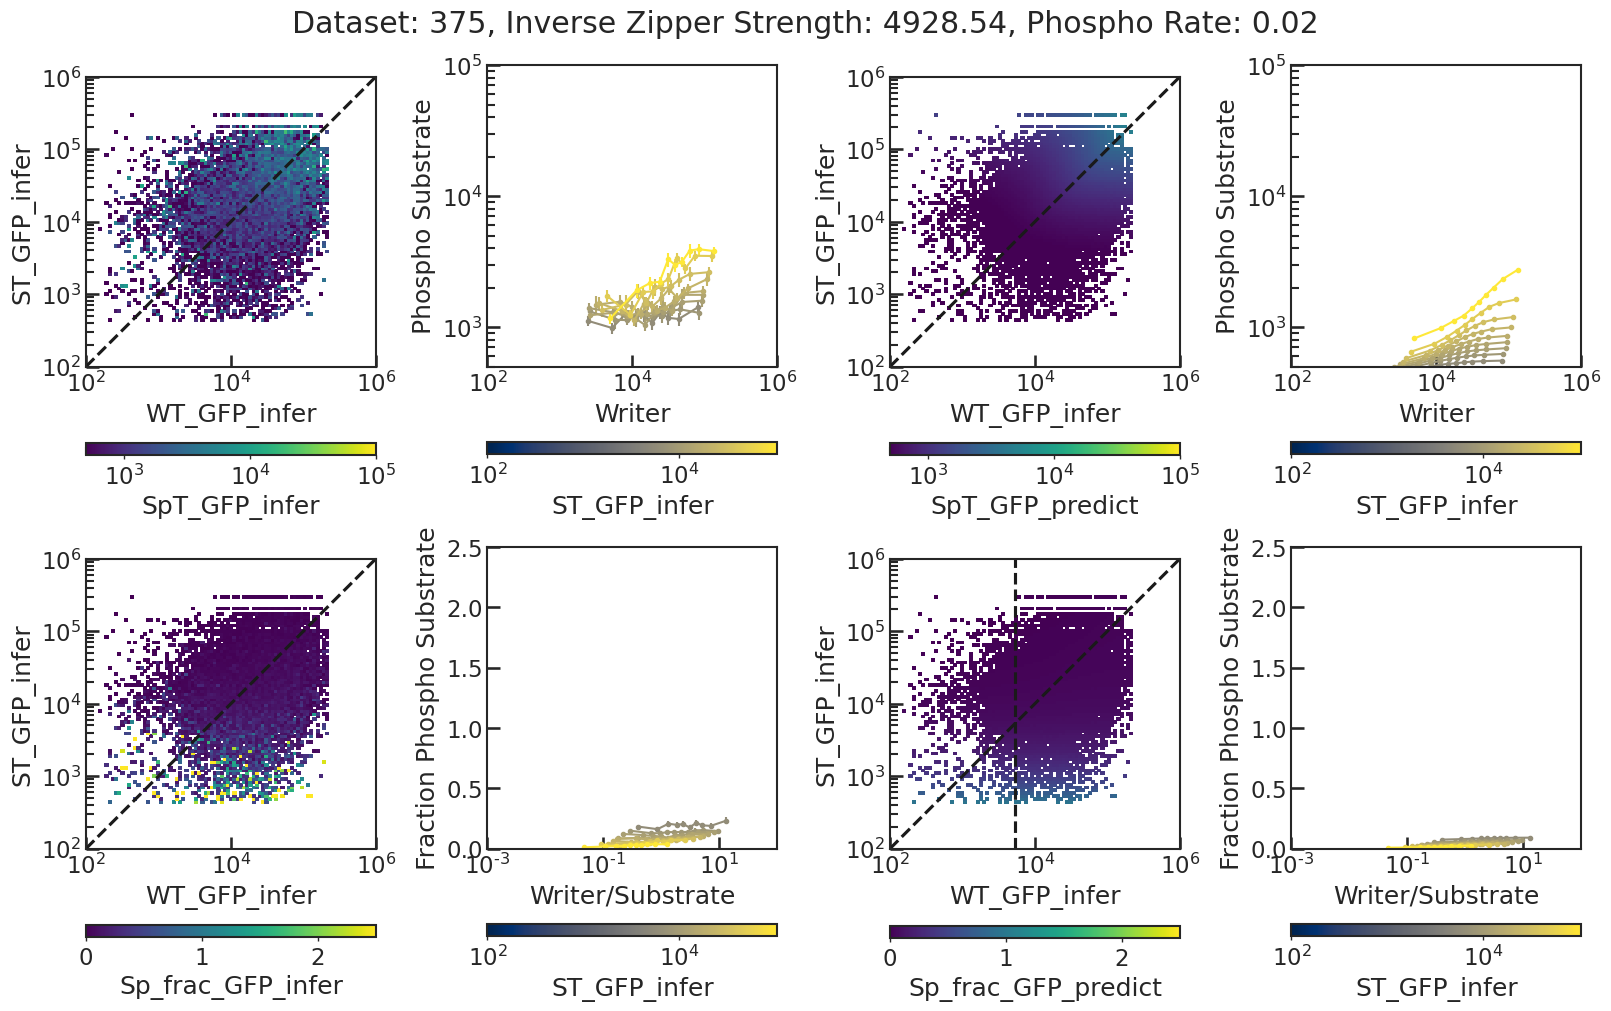

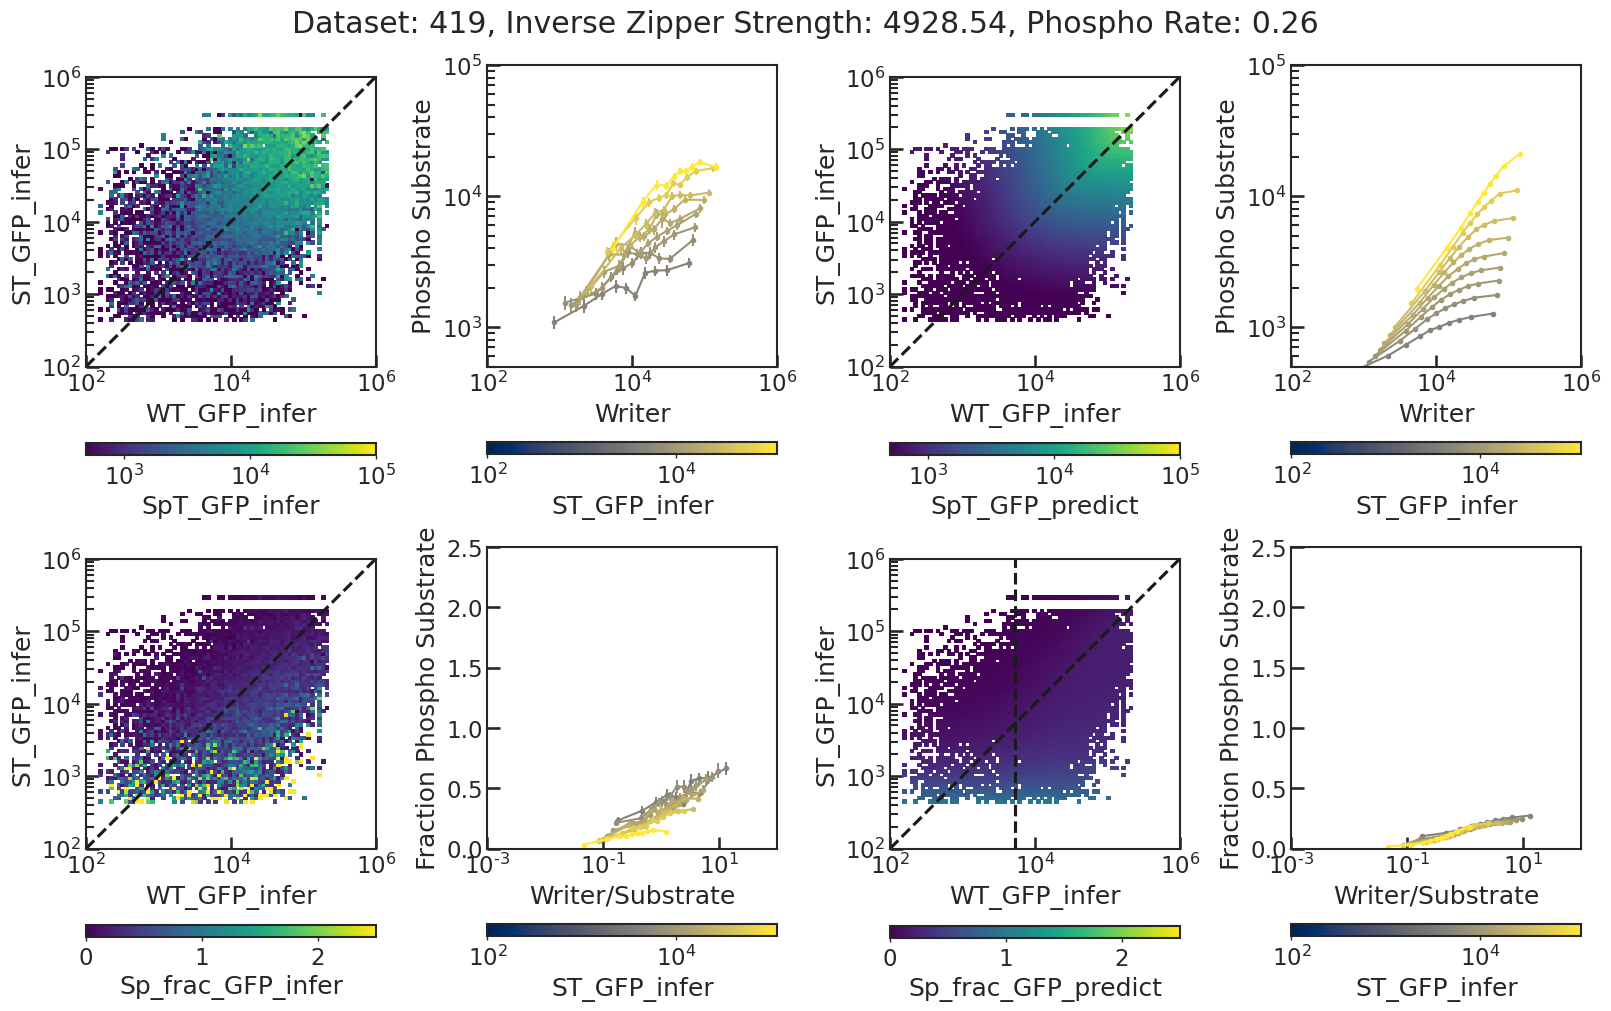

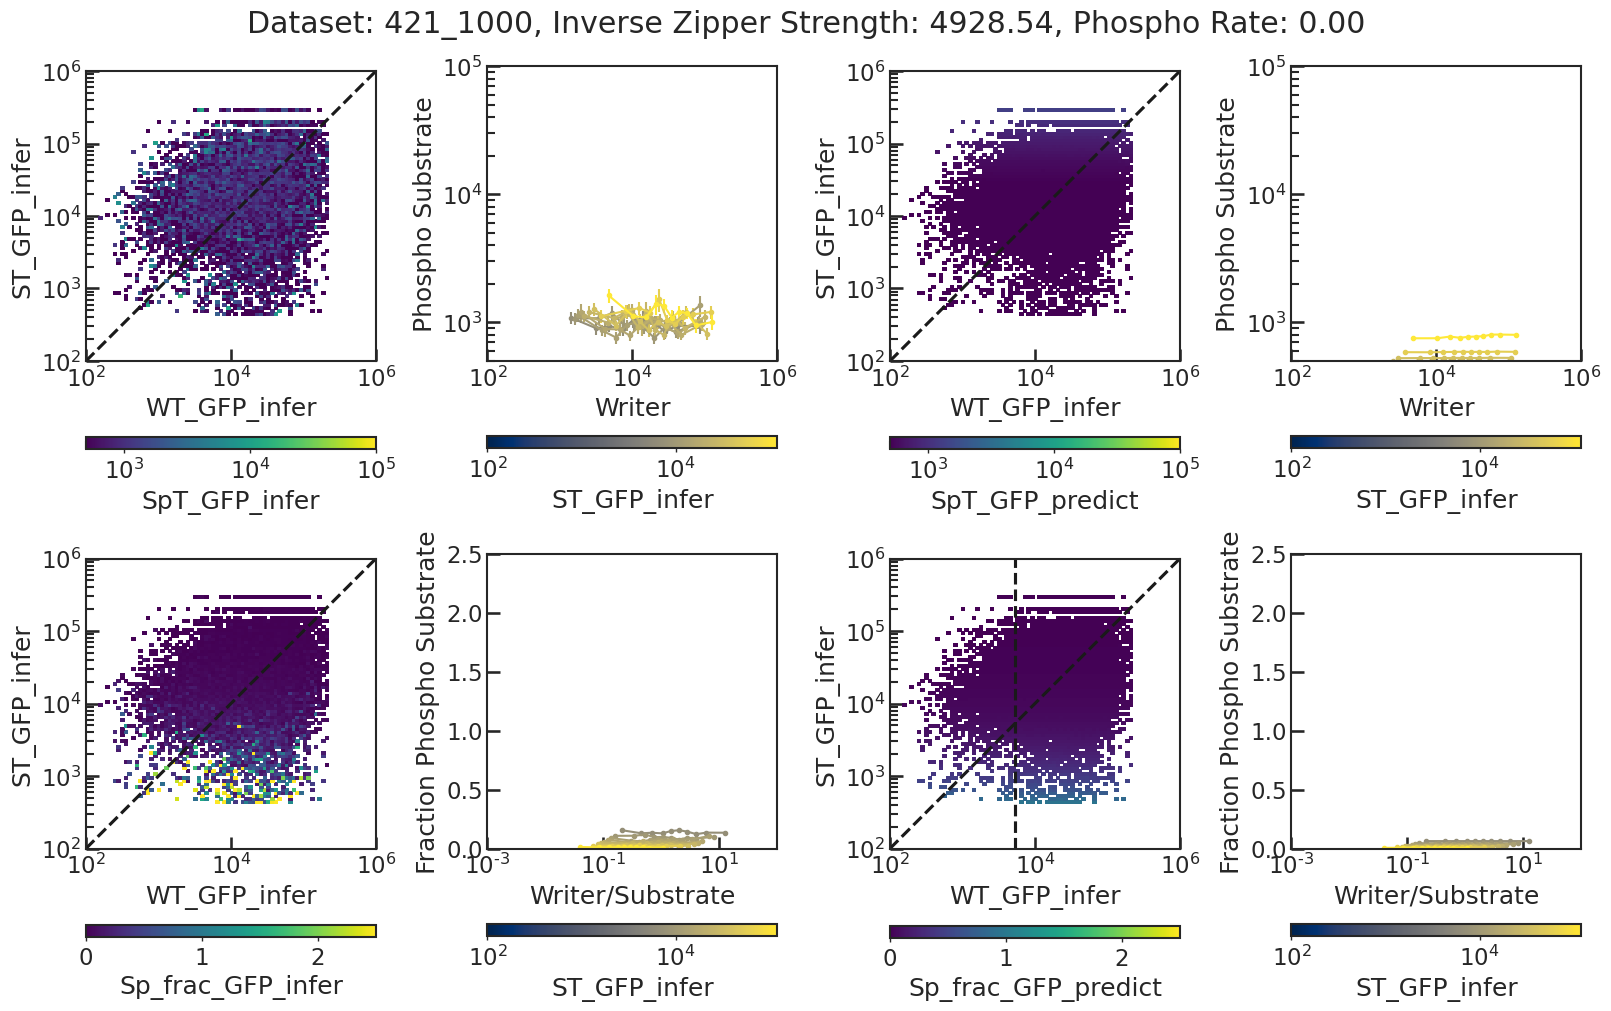

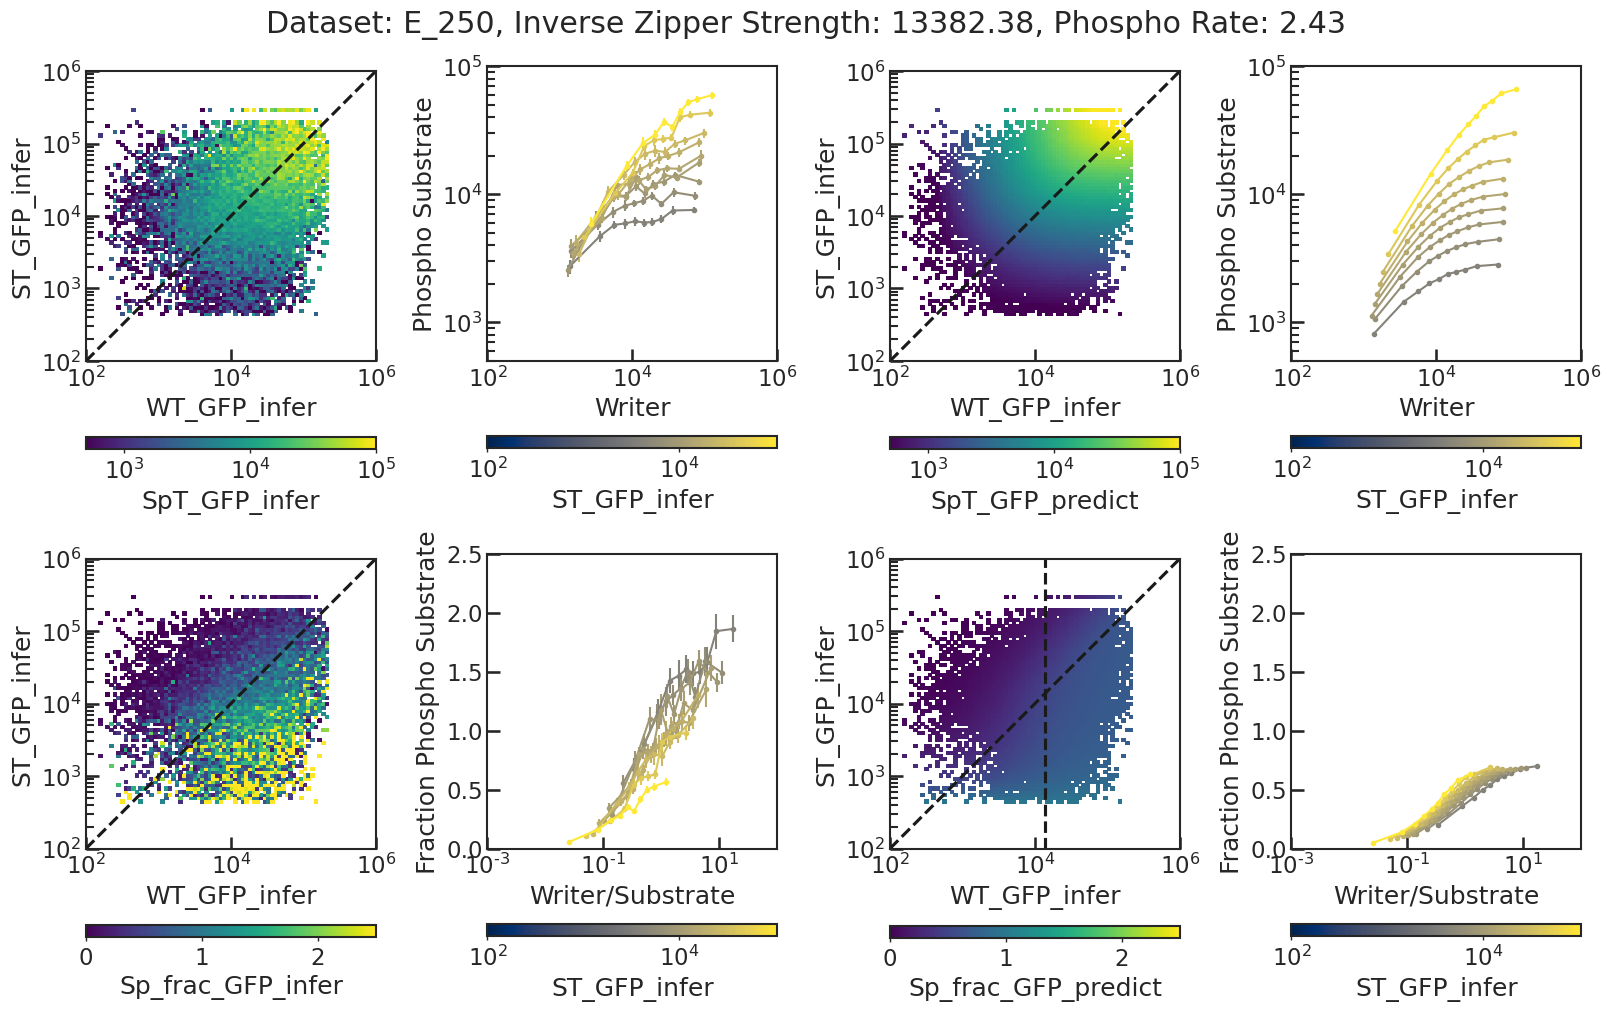

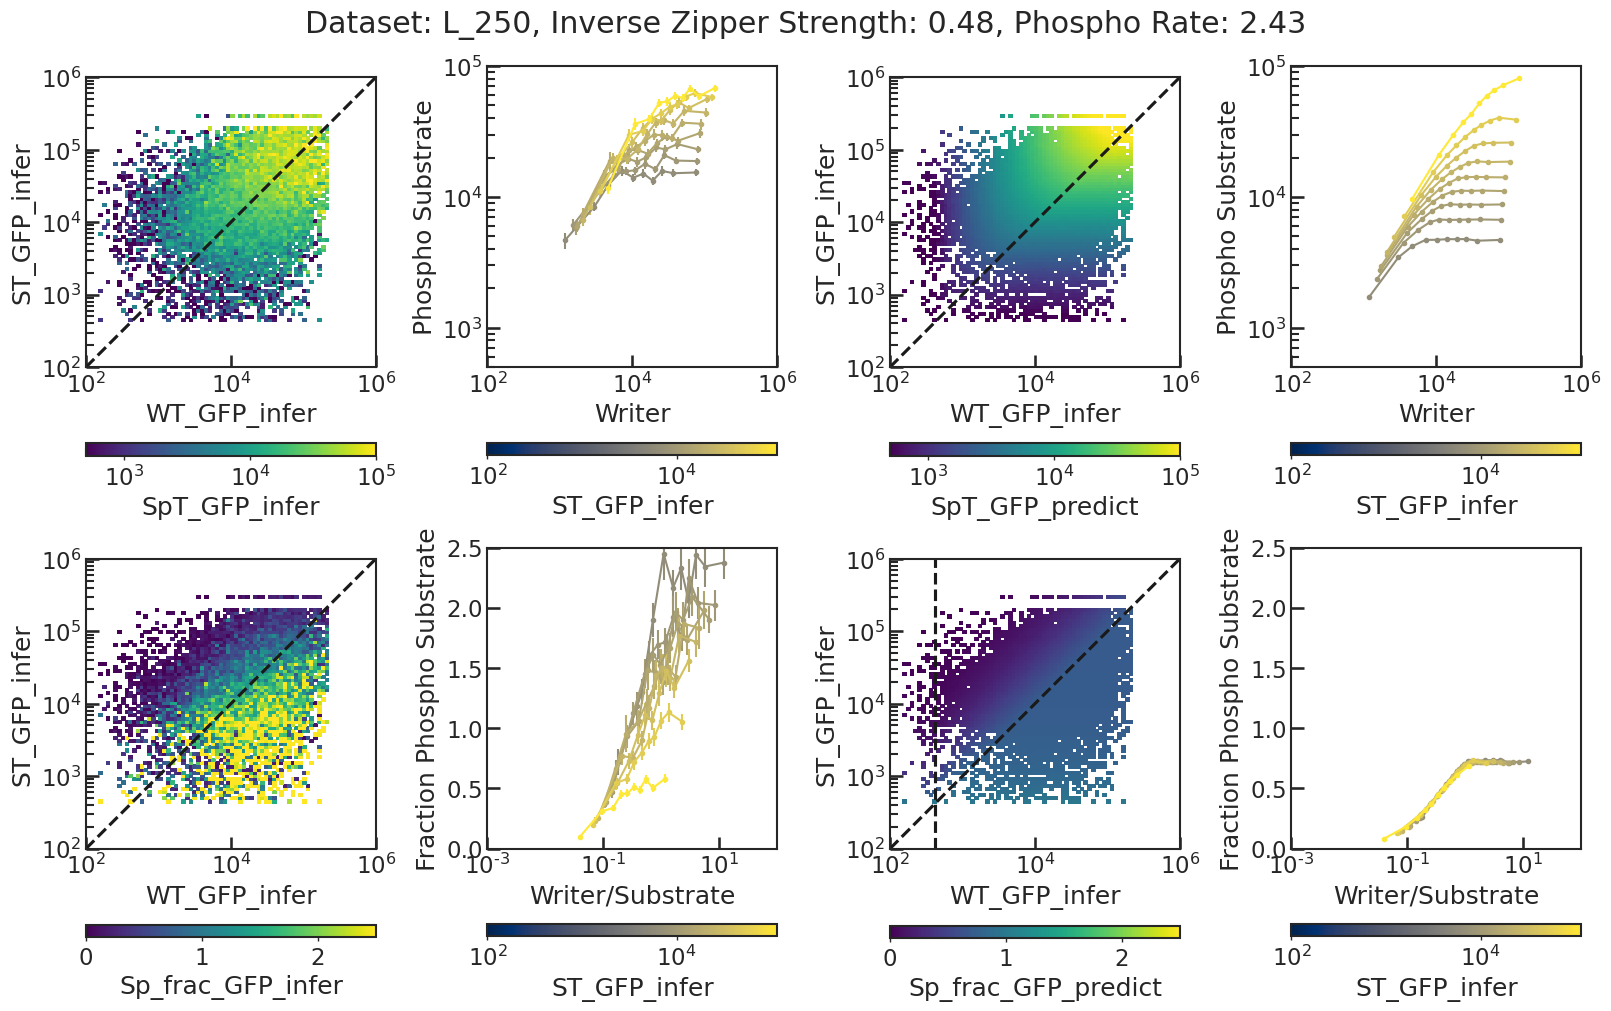

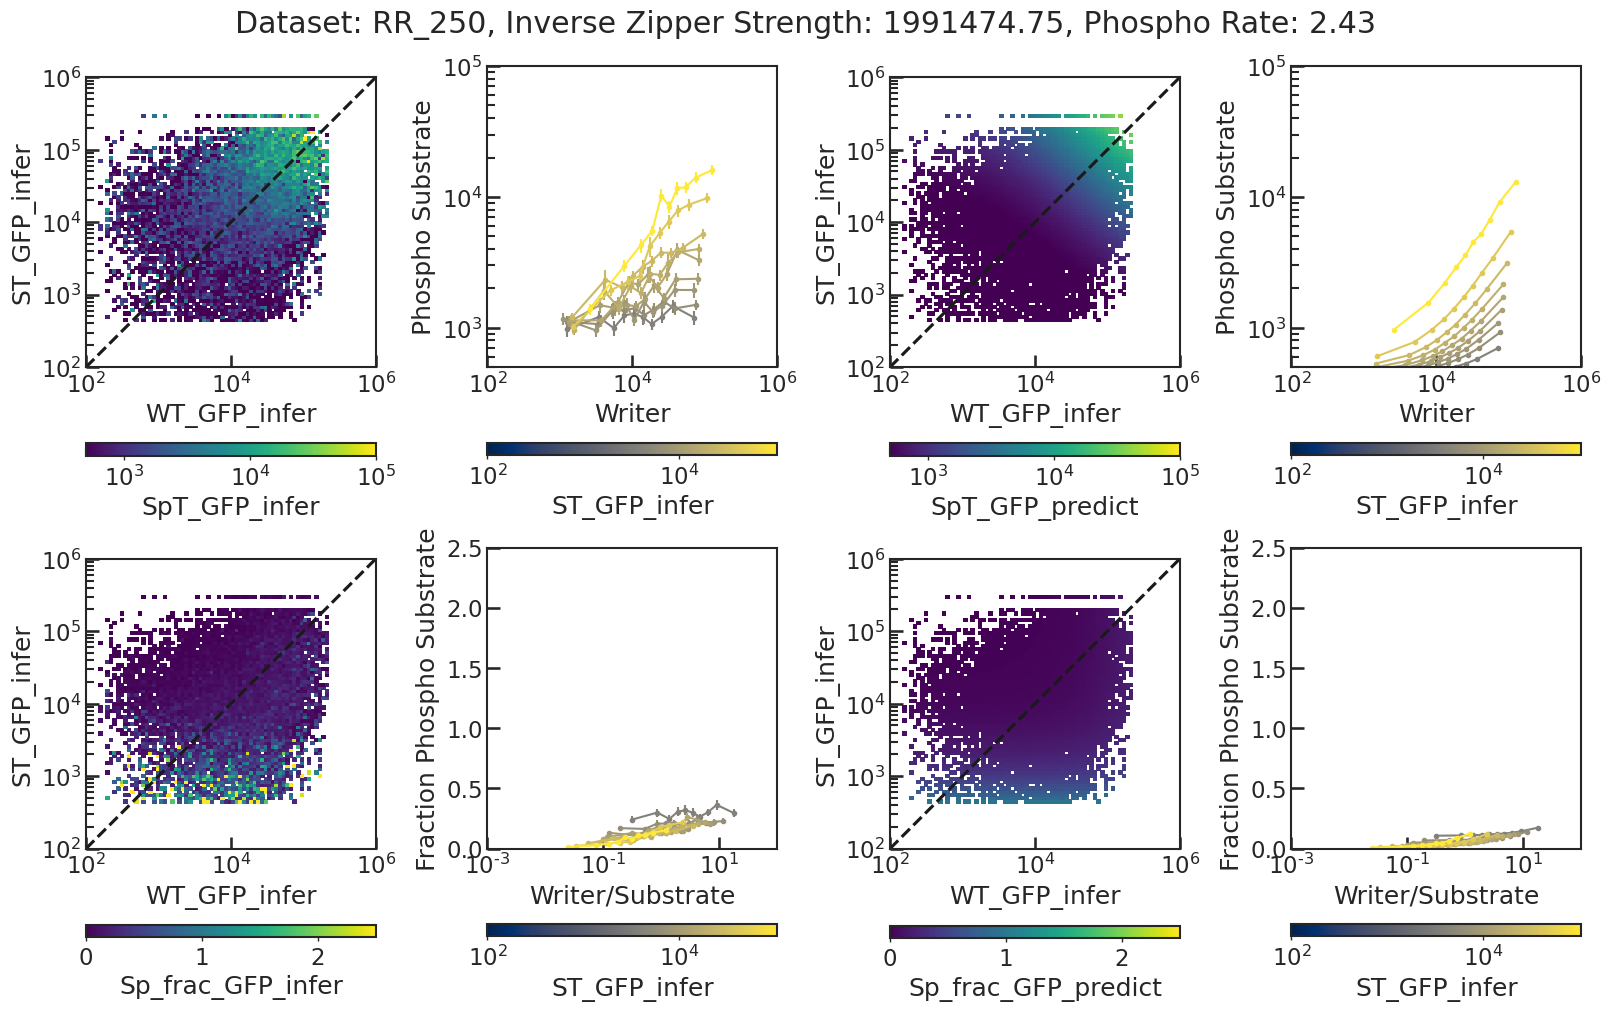

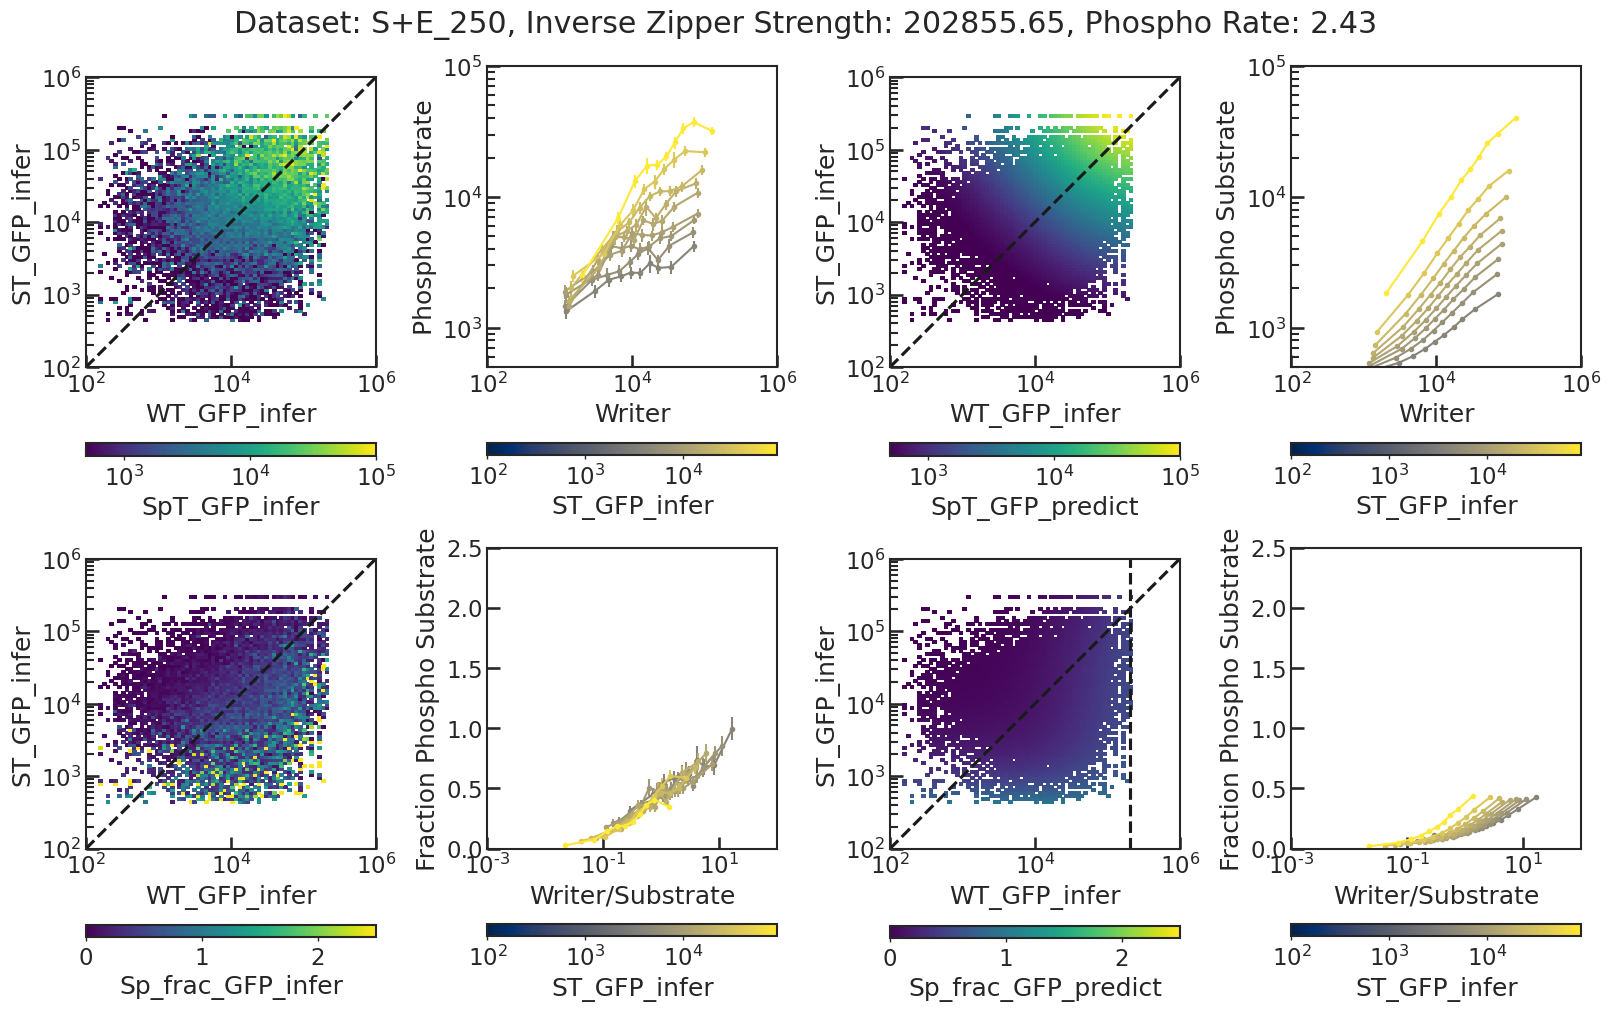

In [13]:
for index, row in df_avg.reset_index().iterrows():

    dataset = row['dataset']
    
    df_tmp = df_data.dropna().query("dataset==@dataset").copy()

    fig = plt.figure(constrained_layout=True, figsize=(16, 10))
    
    gs = fig.add_gridspec(2, 4)

    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_infer', logscale=True, xlim=(1e2, 1e6), ylim=(1e2, 1e6), vmin=0.5e3, vmax=1e5)
    
    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 1])
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 
                                 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_infer', normalizex=False, normalizey=False, xlim=(1e2, 1e6), ylim=(0.5e3, 1e5))
    
    
    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 2])
    
    fplot.plot_2d_avg(df_tmp.copy(), fig, ax, 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_predict', logscale=True, xlim=(1e2, 1e6), ylim=(1e2, 1e6), vmin=0.5e3, vmax=1e5)
    
    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 3])
    
    fplot.plot_activation_curves(df_tmp.copy(), fig, ax, 
                                 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_predict', normalizex=False, normalizey=False, xlim=(1e2, 1e6), ylim=(0.5e3, 1e5))

    
    ##########################################################
    
    
    ax = fig.add_subplot(gs[1, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 'WT_GFP_infer', 'ST_GFP_infer', 'Sp_frac_GFP_infer', logscale=False, xlim=(1e2, 1e6), ylim=(1e2, 1e6), vmin=0, vmax=2.5)
    
    
    ############################################################
    
    
    ax = fig.add_subplot(gs[1, 1])
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 
                                 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_infer', normalizex=True, normalizey=True, xlim=(1e-3, 1e2), ylim=(0.0, 2.5))
    
        
    ############################################################
    
    ax = fig.add_subplot(gs[1, 2])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 'WT_GFP_infer', 'ST_GFP_infer', 'Sp_frac_GFP_predict', logscale=False, xlim=(1e2, 1e6), ylim=(1e2, 1e6), vmin=0, vmax=2.5)
    
    ax.vlines(row['kinase_bind_affin']+np.median(empty_writer_noise.get_GFP()), ymin=1e2, ymax=1e6, ls='--', color='k')

    
    ############################################################
    
    ax = fig.add_subplot(gs[1, 3])
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 
                                 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_predict', normalizex=True, normalizey=True, xlim=(1e-3, 1e2), ylim=(0.0, 2.5))
    
    ##########################################################

    fig.suptitle("Dataset: {0}, Inverse Zipper Strength: {1:.2f}, Phospho Rate: {2:.2f}".format(dataset, row['kinase_bind_affin'], row['kinase_phospho_rate']))

    plt.show()
                
        


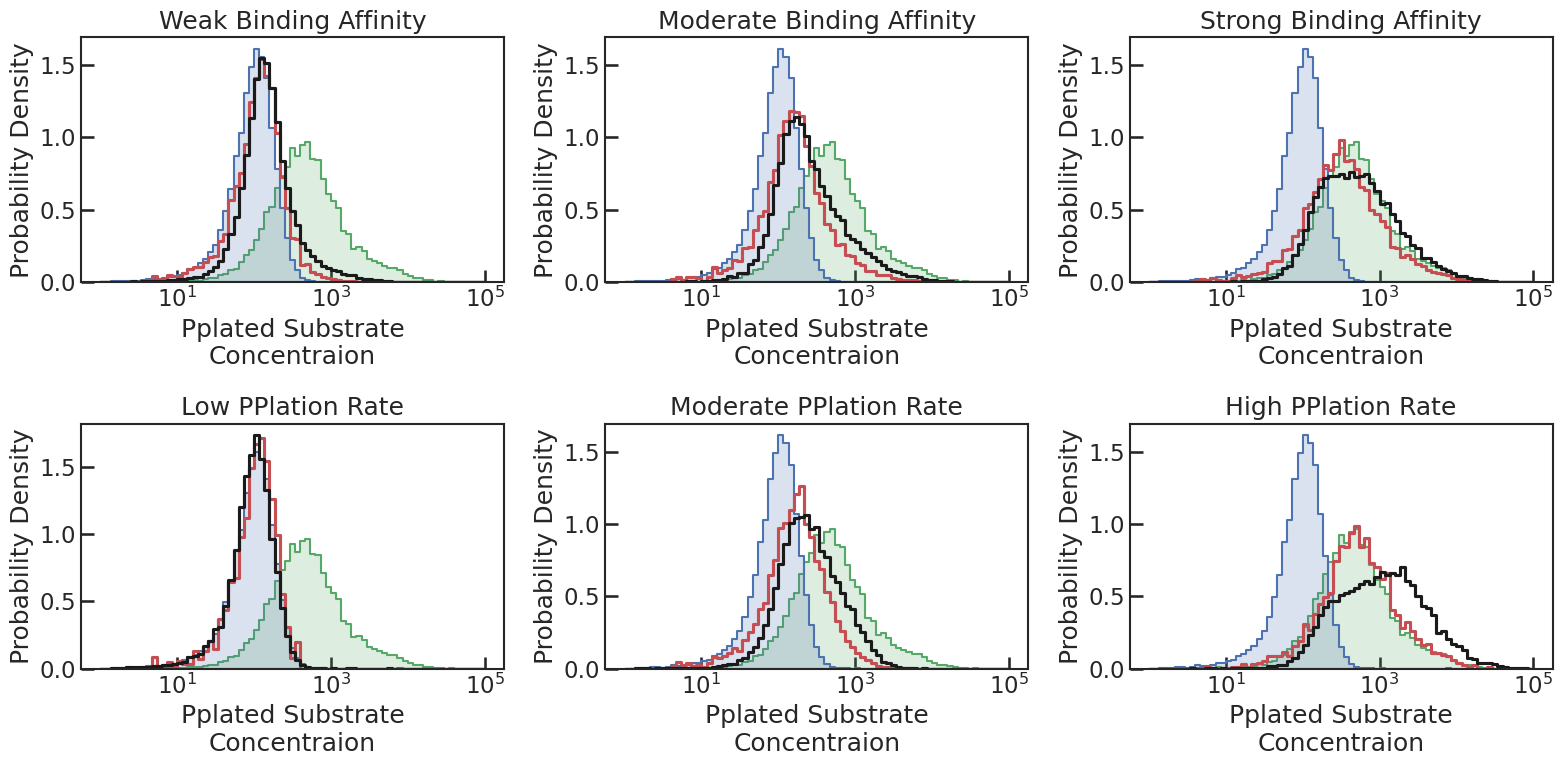

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))


binrange = (0, 5)
nbins = 75

alpha = 0.2


####################################################

ax = axes[0, 0]

dataset = 'RR_250'
    
df_tmp = df_data.query("dataset==@dataset").copy()  
    
sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Active Control', color='g', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Inactive Control', color='b', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(df_tmp['SpT_anti_predict'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Model', color='r', stat='density',
             element='step', fill=False)
sns.histplot(df_tmp['SpT_anti_exp'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Experiment', color='k', stat='density',
             element='step', fill=False)


# ax.set_aspect(4/6/ ax.get_data_ratio())

ax.set_xlabel("Pplated Substrate\nConcentraion")
ax.set_ylabel("Probability Density")
ax.set_title("Weak Binding Affinity")



####################################################


ax = axes[0, 1]

dataset = 'S+E_250'
    
df_tmp = df_data.query("dataset==@dataset").copy()  
    
sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Active Control', color='g', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Inactive Control', color='b', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(df_tmp['SpT_anti_predict'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Model', color='r', stat='density',
             element='step', fill=False)
sns.histplot(df_tmp['SpT_anti_exp'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Experiment', color='k', stat='density',
             element='step', fill=False)


# ax.set_aspect(4/6/ ax.get_data_ratio())

ax.set_xlabel("Pplated Substrate\nConcentraion")
ax.set_ylabel("Probability Density")
ax.set_title("Moderate Binding Affinity")



####################################################



ax = axes[0, 2]

dataset = 'E_250'
    
df_tmp = df_data.query("dataset==@dataset").copy()  
    
sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Active Control', color='g', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Inactive Control', color='b', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(df_tmp['SpT_anti_predict'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Model', color='r', stat='density',
             element='step', fill=False)
sns.histplot(df_tmp['SpT_anti_exp'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Experiment', color='k', stat='density',
             element='step', fill=False)


# ax.set_aspect(4/6/ ax.get_data_ratio())

ax.set_xlabel("Pplated Substrate\nConcentraion")
ax.set_ylabel("Probability Density")
ax.set_title("Strong Binding Affinity")



####################################################


ax = axes[1, 0]

dataset = '421_1000'
    
df_tmp = df_data.query("dataset==@dataset").copy()  
    
sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Active Control', color='g', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Inactive Control', color='b', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(df_tmp['SpT_anti_predict'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Model', color='r', stat='density',
             element='step', fill=False)
sns.histplot(df_tmp['SpT_anti_exp'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Experiment', color='k', stat='density',
             element='step', fill=False)


# ax.set_aspect(4/6/ ax.get_data_ratio())

ax.set_xlabel("Pplated Substrate\nConcentraion")
ax.set_ylabel("Probability Density")
ax.set_title("Low PPlation Rate")



####################################################


ax = axes[1, 1]

dataset = '419'
    
df_tmp = df_data.query("dataset==@dataset").copy()  
    
sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Active Control', color='g', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Inactive Control', color='b', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(df_tmp['SpT_anti_predict'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Model', color='r', stat='density',
             element='step', fill=False)
sns.histplot(df_tmp['SpT_anti_exp'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Experiment', color='k', stat='density',
             element='step', fill=False)


# ax.set_aspect(4/6/ ax.get_data_ratio())

ax.set_xlabel("Pplated Substrate\nConcentraion")
ax.set_ylabel("Probability Density")
ax.set_title("Moderate PPlation Rate")


####################################################


ax = axes[1, 2]

dataset = 'L_250'
    
df_tmp = df_data.query("dataset==@dataset").copy()  
    
sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Active Control', color='g', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Inactive Control', color='b', stat='density',
             element='step', fill=True, alpha=alpha)
sns.histplot(df_tmp['SpT_anti_predict'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Model', color='r', stat='density',
             element='step', fill=False)
sns.histplot(df_tmp['SpT_anti_exp'], binrange=binrange, log_scale=True, 
             bins=nbins, ax=ax, label='Experiment', color='k', stat='density',
             element='step', fill=False)


# ax.set_aspect(4/6/ ax.get_data_ratio())

ax.set_xlabel("Pplated Substrate\nConcentraion")
ax.set_ylabel("Probability Density")
ax.set_title("High PPlation Rate")


####################################################

# handles, labels = ax.get_legend_handles_labels()
# handles = [handles[1], handles[0], handles[3], handles[2]]
# labels = [labels[1], labels[0], labels[3], labels[2]]
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=4)


plt.tight_layout()


plt.show()

